In [1]:
# ------------------------------------------define logging and working directory
from ProjectRoot import change_wd_to_project_root
change_wd_to_project_root()
from src.utils.Notebook_imports import *
from src.utils.Tensorflow_helper import choose_gpu_by_id
from tensorflow.keras.utils import plot_model
from tensorflow.python.client import device_lib
import tensorflow as tf
tf.get_logger().setLevel('ERROR')
import cv2
# ------------------------------------------define GPU id/s to use
GPU_IDS = '0,1'
GPUS = choose_gpu_by_id(GPU_IDS)
print(GPUS)

# ------------------------------------------jupyter magic config
%matplotlib inline
%reload_ext autoreload
%autoreload 2

# ------------------------------------------ import helpers
from src.utils.Utils_io import Console_and_file_logger, init_config
from src.visualization.Visualize import show_2D_or_3D
from src.data.Dataset import get_img_msk_files_from_split_dir, load_acdc_files, get_train_data_from_df, get_trainings_files
from src.data.Generators import DataGenerator, CycleMotionDataGenerator
from src.utils.KerasCallbacks import get_callbacks
import src.utils.Metrics_own as metr
import src.models.SpatialTransformer as st
from src.models.SpatialTransformer import create_affine_cycle_transformer_model
from src.models.ModelUtils import load_pretrained_model

# ------------------------------------------path and project params
ARCHITECTURE = '3D' # 2D
DATASET = 'GCN'  # 'acdc' # or 'gcn' or different versions such as gcn_01/02
FOLD = 1 # CV fold 0-3
EXP_NAME = 'ax_sax/unetwithdownsamplingaugmentation_new_data' # Define an experiment name, could have subfolder conventions
EXPERIMENT = '{}/{}'.format(ARCHITECTURE, EXP_NAME) # Uniform path names, separation of concerns
timestemp = str(datetime.datetime.now().strftime("%Y-%m-%d_%H_%M")) # ad a timestep to each project to make repeated experiments unique

# Our generator expects the following fix data structure (could be changed in src/data/Generators)
# any-path/
#    - AX_3D(anyname_img.nrrd and anyname_msk.nrrd)
#    - AX_to_SAX_3D
#    - SAX_3D
#    - SAX_to_AX_3D
DATA_PATH_AX = '/mnt/ssd/data/gcn/ax_sax_from_flo/AX_3D/' # path to AX 3D files
DATA_PATH_AX2SAX = DATA_PATH_AX.replace('AX_3D', 'AX_to_SAX_3D') # path to ax2sax 3D files
DF_PATH = '/mnt/ssd/data/gcn/gcn_05_2020_ax_sax_86/folds.csv' # path to folds dataframe

MODEL_PATH = os.path.join('models', EXPERIMENT, timestemp)
TENSORBOARD_LOG_DIR = os.path.join('reports/tensorboard_logs', EXPERIMENT,timestemp)
CONFIG_PATH = os.path.join('reports/configs/',EXPERIMENT,timestemp)
HISTORY_PATH = os.path.join('reports/history/',EXPERIMENT,timestemp)

# ------------------------------------------static model, loss and generator hyperparameters
DIM = [80, 112, 112] # network input params for spacing of 3, (z,y,x)
DEPTH = 4 # number of down-/upsampling blocks
FILTERS = 16 # initial number of filters, will be doubled after each downsampling block
SPACING = [3, 3, 3] # if resample, resample to this spacing, (z,y,x)
M_POOL = [2, 2, 2]# size of max-pooling used for downsampling and upsampling
F_SIZE = [3, 3, 3] # conv filter size
IMG_CHANNELS = 1 # Currently our model needs that image channel
MASK_VALUES = [1, 2, 3]  #channel order: Background, RV, MYO, LV
MASK_CLASSES = len(MASK_VALUES) # no of labels
BORDER_MODE = cv2.BORDER_REFLECT_101 # border mode for the data generation
IMG_INTERPOLATION = cv2.INTER_LINEAR # image interpolation in the genarator
MSK_INTERPOLATION = cv2.INTER_NEAREST # mask interpolation in the generator
AUGMENT = False # Not implemented for the AX2SAX case
SHUFFLE = True
AUGMENT_GRID = False # Not implemented for the AX2SAX case
RESAMPLE = True
SCALER = 'MinMax' # MinMax Standard or Robust

AX_LOSS_WEIGHT = 10.0 # weighting factor of the ax2sax loss
WEIGHT_MSE_INPLANE = True # turn inplane weighting on/off
MASK_SMALLER_THAN_THRESHOLD = 0.001 # define the threshold for masking the ax2sax/sax2ax MSE loss, areas with smaller values, will be masked out

SAX_LOSS_WEIGHT = 10.0 # weighting factor of the sax2ax loss
CYCLE_LOSS = True # turn this loss on/off

FOCUS_LOSS_WEIGHT = 1.0 # weighting of the focus loss
FOCUS_LOSS = True # turn this loss on/off
USE_SAX2AX_PROB = False # apply the focus loss on SAX predictions, or on SAX2AX (back-transformed) predictions
MIN_UNET_PROBABILITY = 0.8 # threshold to count only prediction greater than this value for the focus loss

# ------------------------------------------individual training params
GENERATOR_WORKER = 2 # no of parallel workers in our generator. if not set, use batchsize, numbers greater than batchsize does not make any sense
SEED = 42 # define a seed for the generator shuffle
BATCHSIZE = 2 # 32, 64, 24, 16, 1 for 3spacing 3,3,3 use: 2
INITIAL_EPOCH = 0 # change this to continue training
EPOCHS = 300 # define a maximum numbers of epochs
EPOCHS_BETWEEN_CHECKPOINTS = 5
MONITOR_FUNCTION = 'val_loss'
MONITOR_MODE = 'min'
SAVE_MODEL_FUNCTION = 'val_loss'
SAVE_MODEL_MODE = 'min'
MODEL_PATIENCE = 20
BN_FIRST = False # decide if batch normalisation between conv and activation or afterwards
BATCH_NORMALISATION = True # apply BN or not
USE_UPSAMPLE = True # otherwise use transpose for upsampling
PAD = 'same' # padding strategy of the conv layers
KERNEL_INIT = 'he_normal' # conv weight initialisation
OPTIMIZER = 'adam' # Adam, Adagrad, RMSprop, Adadelta,  # https://keras.io/optimizers/
ACTIVATION = 'elu' # tf.keras.layers.LeakyReLU(), relu or any other non linear activation function
LEARNING_RATE = 1e-4 # start with a huge lr to converge fast
DECAY_FACTOR = 0.3 # Define a learning rate decay for the ReduceLROnPlateau callback
MIN_LR = 1e-10 # minimal lr, smaller lr does not improve the model
DROPOUT_min = 0.3 # lower dropout at the shallow layers
DROPOUT_max = 0.5 # higher dropout at the deep layers

# ------------------------------------------these metrics and loss function are meant if you continue training of the U-Net
metrics = [
    metr.dice_coef_labels,
    metr.dice_coef_myo,
    metr.dice_coef_lv,
    metr.dice_coef_rv
]
LOSS_FUNCTION = metr.bce_dice_loss

# Create a logger instance with the following setup: info or debug to console and file and error logs to a separate file
# Define a config for param injection,
# save a serialized version to load the experiment for prediction/evaluation, 
# make sure all paths exist
Console_and_file_logger(EXPERIMENT, logging.INFO)
config = init_config(config=locals(), save=True)
print(config)

search for root_dir and set working directory
Working directory set to: /mnt/ssd/git/3d-mri-domain-adaption
['/gpu:0', '/gpu:1']


2020-12-03 08:01:21,000 INFO -------------------- Start --------------------
2020-12-03 08:01:21,001 INFO Working directory: /mnt/ssd/git/3d-mri-domain-adaption.
2020-12-03 08:01:21,001 INFO Log file: ./logs/3D/ax_sax/unetwithdownsamplingaugmentation_new_data.log
2020-12-03 08:01:21,002 INFO Log level for console: INFO


{'GPU_IDS': '0,1', 'GPUS': ['/gpu:0', '/gpu:1'], 'ARCHITECTURE': '3D', 'DATASET': 'GCN', 'FOLD': 1, 'EXP_NAME': 'ax_sax/unetwithdownsamplingaugmentation_new_data', 'EXPERIMENT': '3D/ax_sax/unetwithdownsamplingaugmentation_new_data', 'DATA_PATH_AX': '/mnt/ssd/data/gcn/ax_sax_from_flo/AX_3D/', 'DATA_PATH_AX2SAX': '/mnt/ssd/data/gcn/ax_sax_from_flo/AX_to_SAX_3D/', 'DF_PATH': '/mnt/ssd/data/gcn/gcn_05_2020_ax_sax_86/folds.csv', 'MODEL_PATH': 'models/3D/ax_sax/unetwithdownsamplingaugmentation_new_data/2020-12-03_08_01', 'TENSORBOARD_LOG_DIR': 'reports/tensorboard_logs/3D/ax_sax/unetwithdownsamplingaugmentation_new_data/2020-12-03_08_01', 'CONFIG_PATH': 'reports/configs/3D/ax_sax/unetwithdownsamplingaugmentation_new_data/2020-12-03_08_01', 'HISTORY_PATH': 'reports/history/3D/ax_sax/unetwithdownsamplingaugmentation_new_data/2020-12-03_08_01', 'DIM': [80, 112, 112], 'DEPTH': 4, 'FILTERS': 16, 'SPACING': [3, 3, 3], 'M_POOL': [2, 2, 2], 'F_SIZE': [3, 3, 3], 'IMG_CHANNELS': 1, 'MASK_VALUES': [1, 

# Check Tensorflow setup and available GPUs

In [2]:
from tensorflow.keras.mixed_precision import experimental as mixed_precision
logging.info('Is built with tensorflow: {}'.format(tf.test.is_built_with_cuda()))
logging.info('Visible devices:\n{}'.format(tf.config.list_physical_devices()))
logging.info('Local devices: \n {}'.format(device_lib.list_local_devices()))
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_policy(policy)
logging.info('Compute dtype: %s' % policy.compute_dtype)
logging.info('Variable dtype: %s' % policy.variable_dtype)

2020-12-03 08:01:23,879 INFO Is built with tensorflow: True
2020-12-03 08:01:23,959 INFO Visible devices:
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'), PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU'), PhysicalDevice(name='/physical_device:XLA_GPU:1', device_type='XLA_GPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
2020-12-03 08:01:24,591 INFO Local devices: 
 [name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7979480498146233651
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 12631228515708551810
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 3715385831302456162
physical_device_desc:

# Load trainings and validation files for the choosen fold

In [3]:
# Load AX volumes
x_train_ax, y_train_ax, x_val_ax, y_val_ax =  get_trainings_files(data_path=DATA_PATH_AX,path_to_folds_df=DF_PATH, fold=FOLD)

logging.info('AX x_train files: {}, AX y_train files: {}'.format(len(x_train_ax), len(y_train_ax)))
logging.info('AX x_val files: {}, AX y_val files: {}'.format(len(x_val_ax), len(y_val_ax)))

# load AX2SAX volumes, they should be in the same directory but with a different suffix --> AX_to_SAX_3D
x_train_sax, y_train_sax, x_val_sax, y_val_sax =  get_trainings_files(data_path=DATA_PATH_AX2SAX,path_to_folds_df=DF_PATH, fold=FOLD)
config = init_config(config)

logging.info('x_train files: {}, y_train files: {}'.format(len(x_train_sax), len(y_train_sax)))
logging.info('x_val files: {}, y_val files: {}'.format(len(x_val_sax), len(y_val_sax)))

2020-12-03 08:01:24,823 INFO Found 162 images/masks in /mnt/ssd/data/gcn/ax_sax_from_flo/AX_3D/
2020-12-03 08:01:24,824 INFO Patients train: 64
2020-12-03 08:01:24,830 INFO Selected 124 of 162 files with 64 of 86 patients for training fold 1
2020-12-03 08:01:24,830 INFO AX x_train files: 124, AX y_train files: 124
2020-12-03 08:01:24,831 INFO AX x_val files: 38, AX y_val files: 38
2020-12-03 08:01:24,836 INFO Found 162 images/masks in /mnt/ssd/data/gcn/ax_sax_from_flo/AX_to_SAX_3D/
2020-12-03 08:01:24,836 INFO Patients train: 64
2020-12-03 08:01:24,842 INFO Selected 124 of 162 files with 64 of 86 patients for training fold 1
2020-12-03 08:01:24,844 INFO x_train files: 124, y_train files: 124
2020-12-03 08:01:24,844 INFO x_val files: 38, y_val files: 38


In [4]:
# filter files by name, debugging purpose
#x_val_ax = [x for x in x_val_ax if '4A4PVCYL_2006' in x]
#x_val_sax = [x for x in x_val_sax if '4A4PVCYL_2006' in x]
#y_val_ax = [x for x in y_val_ax if '4A4PVCYL_2006' in x]
print(len(x_val_ax))
print(len(x_val_sax))
print(len(y_val_ax))

38
38
38


In [5]:
# create two generators, one for the training files, one for the validation files
batch_generator = CycleMotionDataGenerator(x_train_ax, x_train_sax, config)
valid_config = config.copy()
valid_config['AUGMENT_GRID'] = False
valid_config['AUGMENT'] = False
valid_generator = CycleMotionDataGenerator(x_val_ax, x_val_sax, valid_config)

2020-12-03 08:01:25,834 INFO Create DataGenerator
2020-12-03 08:01:25,835 INFO Datagenerator created with: 
 shape: [80, 112, 112]
 spacing: [3, 3, 3]
 batchsize: 2
 Scaler: MinMax
 Images: 124 
 Augment_grid: False 
 Thread workers: 2
2020-12-03 08:01:25,835 INFO No augmentation
2020-12-03 08:01:25,836 INFO Create DataGenerator
2020-12-03 08:01:25,836 INFO Datagenerator created with: 
 shape: [80, 112, 112]
 spacing: [3, 3, 3]
 batchsize: 2
 Scaler: MinMax
 Images: 38 
 Augment_grid: False 
 Thread workers: 2
2020-12-03 08:01:25,837 INFO No augmentation


In [6]:
# Select batch generator output
x = ''
y = ''
@interact
def select_batch(batch = (0,len(valid_generator), 1)):
    global x, y, x2, y2
    input_ , output_ = valid_generator.__getitem__(batch)
    x = input_[0]
    y = output_[0]
    x2 = input_[1]
    y2 = output_[1]
    logging.info('input elements: {}'.format(len(input_)))
    logging.info('output elements: {}'.format(len(output_)))
    logging.info(x.shape)
    logging.info(y.shape)
    logging.info(x2.shape)
    logging.info(y2.shape)

interactive(children=(IntSlider(value=9, description='batch', max=19), Output()), _dom_classes=('widget-intera…

In [7]:
@interact
def select_image_in_batch(im = (0,x.shape[0]- 1, 1),slice_by=(1,6)):
    
    # define a different logging level to make the generator steps visible
    logging.getLogger().setLevel(logging.DEBUG)
    temp_dir = 'reports/figures/temp/'
    ensure_dir(temp_dir)

    logging.info('AX: {}'.format(x[im].shape))
    show_2D_or_3D(x[im][...,0][::slice_by])
    plt.savefig(os.path.join(temp_dir,'ax.pdf'))
    plt.show()
    logging.info('AXtoSAX: {}'.format(y[im].shape))
    show_2D_or_3D(y[im][...,0][::slice_by])
    plt.savefig(os.path.join(temp_dir,'ax2sax.pdf'))
    plt.show()
    logging.info('SAX: {}'.format(x2[im].shape))
    show_2D_or_3D(x2[im][...,0][::slice_by])
    plt.savefig(os.path.join(temp_dir,'sax.pdf'))
    plt.show()
    logging.info('SAXtoAX: {}'.format(y2[im].shape))
    show_2D_or_3D(y2[im][...,0][::slice_by])
    plt.savefig(os.path.join(temp_dir,'sax2ax.pdf'))
    plt.show()
    

interactive(children=(IntSlider(value=0, description='im', max=1), IntSlider(value=3, description='slice_by', …

In [8]:
# load a pretrained 2D unet
"""
load past config for model training 
"""
if 'strategy' not in globals():
    # distribute the training with the mirrored data paradigm across multiple gpus if available, if not use gpu 0
    strategy = tf.distribute.MirroredStrategy(devices=config.get('GPUS', ["/gpu:0"]))
    
if 'config_chooser' in locals():
    config_file  = config_chooser.selected
else:
    #config_file = '/mnt/ssd/git/3d-mri-domain-adaption/reports/configs/2D/gcn_and_acdc_excl_ax/config.json' # config for TMI paper
    config_file = '/mnt/ssd/git/cardio/reports/configs/2D/gcn_05_2020_sax_excl_ax_patients/2020-11-20_17_24/config.json' # retrained with downsampling

# load config with all params into global namespace
with open(config_file, encoding='utf-8') as data_file:
    config_temp = json.loads(data_file.read())
config_temp['LOSS_FUNCTION'] = config['LOSS_FUNCTION']
logging.info('Load model from Experiment: {}'.format(config_temp['EXPERIMENT']))

with strategy.scope():
    globals()['unet'] = load_pretrained_model(config_temp, metrics, comp=False)

2020-12-03 08:01:28,603 INFO Load model from Experiment: 2D/gcn_05_2020_sax_excl_ax_patients
2020-12-03 08:01:28,603 INFO load model with keras api
2020-12-03 08:01:30,910 INFO Unable to restore custom object of type _tf_keras_metric currently. Please make sure that the layer implements `get_config`and `from_config` when saving. In addition, please use the `custom_objects` arg when calling `load_model()`.
2020-12-03 08:01:30,915 INFO Keras API failed, use json repr. load model from: models/2D/gcn_05_2020_sax_excl_ax_patients/2020-11-20_17_24/model.json .
2020-12-03 08:01:30,915 INFO loading model description
2020-12-03 08:01:31,851 INFO loading model weights
2020-12-03 08:01:32,036 INFO model models/2D/gcn_05_2020_sax_excl_ax_patients/2020-11-20_17_24/model.json loaded


In [9]:
if 'strategy' not in globals():
    # distribute the training with the mirrored data paradigm across multiple gpus if available, if not use gpu 0
    strategy = tf.distribute.MirroredStrategy(devices=config.get('GPUS', ["/gpu:0"]))
# inject the pre-trained unet if given, otherwise build the model without the pretrained unet
with strategy.scope():
    model = st.create_affine_cycle_transformer_model(config=config, metrics=metrics, unet=locals().get('unet', None))

2020-12-03 08:01:34,402 INFO unet given, use it to max probability
2020-12-03 08:01:53,538 INFO adding ax2sax MSE loss with a weighting of 10.0
2020-12-03 08:01:53,539 INFO adding cycle loss with a weighting of 10.0
2020-12-03 08:01:53,540 INFO adding focus loss on mask_prob with a weighting of 1.0


In [10]:
model.summary(line_length=150)
#plot_model(model, to_file='reports/figures/temp_graph.pdf',show_shapes=True)

Model: "affine_cycle_transformer"
______________________________________________________________________________________________________________________________________________________
Layer (type)                                     Output Shape                     Param #           Connected to                                      
input_1 (InputLayer)                             [(None, 80, 112, 112, 1)]        0                                                                   
______________________________________________________________________________________________________________________________________________________
conv_encoder (ConvEncoder)                       ((None, 5, 7, 7, 256), [(None, 8 3537424           input_1[0][0]                                     
______________________________________________________________________________________________________________________________________________________
global_average_pooling3d (GlobalAveragePooling3D (None, 256)

In [11]:
@interact
def select_image_in_batch(im = (0,x.shape[0]- 1, 1),mask_smaller_than='0.001', slice_by=(1,6)):
    global m
    import numpy as np
    temp = x[im]
    sax = x2[im]
    temp_ = y[im]
    
    mask = temp_ >float(mask_smaller_than)
    # define a different logging level to make the generator steps visible
    logging.getLogger().setLevel(logging.INFO)
    logging.info('prediction on: {}'.format(temp.shape))
    show_2D_or_3D(temp[::slice_by])
    plt.show()
    pred, inv_pred, ax2sax_mod, prob, ax_msk,m, m_mod = model.predict(x = [np.expand_dims(temp,axis=0),np.expand_dims(sax,axis=0)])                     
    logging.info('rotated by the model: {}'.format(pred[0].shape))
    show_2D_or_3D(pred[0][::slice_by], mask[::slice_by])
    plt.show()
    logging.info('inverse rotation on SAX: {}'.format(inv_pred[0].shape))
    show_2D_or_3D(inv_pred[0][::slice_by])
    plt.show()
    logging.info('predicted mask: {}'.format(inv_pred[0].shape))
    show_2D_or_3D(prob[0][::slice_by])
    plt.show()
    logging.info('predicted mask in ax: {}'.format(ax_msk[0].shape))
    show_2D_or_3D(ax_msk[0][::slice_by])
    plt.show()
    
    # calculate the loss mask from target AX2SAX image
    mask = temp_ >float(mask_smaller_than)
    logging.info('masked by GT: {}'.format(mask.shape))
    masked = pred[0] * mask
    show_2D_or_3D(masked[::slice_by], mask[::slice_by])
    plt.show()
    logging.info('target (AX2SAX): {}'.format(temp_.shape))
    show_2D_or_3D(temp_[::slice_by])
    plt.show()
    logging.info('Created MSE mask by thresholding the target (AX2SAX) with {}: {}'.format(mask_smaller_than,temp_.shape))
    show_2D_or_3D(mask[::slice_by])
    plt.show()

    try:
        from tensorflow.keras.metrics import MSE as mse
        logging.info('MSE: {}'.format(mse(pred[0], temp_).numpy().mean()))
        logging.info('prob loss: {}'.format(metr.max_volume_loss(min_probabillity=0.5)(temp_[tf.newaxis,...],prob).numpy().mean()))
        print(np.reshape(m[0],(3,4)))
        print(np.reshape(m_mod[0],(3,4)))
    except Exception as e:
        pass

interactive(children=(IntSlider(value=0, description='im', max=1), Text(value='0.001', description='mask_small…

In [ ]:
# train one model
initial_epoch = 0
logging.info('Fit model, start trainings process')
# fit model with trainingsgenerator
results = model.fit(
    x=batch_generator,
    validation_data=valid_generator,
    validation_steps=len(valid_generator),
    epochs=200,
    callbacks = get_callbacks(config, valid_generator),
    steps_per_epoch = len(batch_generator),
    initial_epoch=initial_epoch,
    verbose=1)

2020-12-03 08:02:49,908 INFO Fit model, start trainings process


Epoch 1/200
62/62 [==============================] - ETA: 0s - loss: 20.9674 - ax2sax_loss: 1.1150 - sax2ax_loss: 0.8825 - mask_prob_loss: 0.9922
Epoch 00001: val_loss improved from inf to 21.51469, saving model to models/3D/ax_sax/unetwithdownsamplingaugmentation_new_data/2020-12-03_08_01/model.h5
62/62 [==============================] - 166s 3s/step - loss: 20.9674 - ax2sax_loss: 1.1150 - sax2ax_loss: 0.8825 - mask_prob_loss: 0.9922 - val_loss: 21.5147 - val_ax2sax_loss: 1.1400 - val_sax2ax_loss: 0.9123 - val_mask_prob_loss: 0.9924 - lr: 1.0000e-04
Epoch 2/200
62/62 [==============================] - ETA: 0s - loss: 20.5481 - ax2sax_loss: 1.0890 - sax2ax_loss: 0.8665 - mask_prob_loss: 0.9928
Epoch 00002: val_loss improved from 21.51469 to 21.44562, saving model to models/3D/ax_sax/unetwithdownsamplingaugmentation_new_data/2020-12-03_08_01/model.h5
62/62 [==============================] - 126s 2s/step - loss: 20.5481 - ax2sax_loss: 1.0890 - sax2ax_loss: 0.8665 - mask_prob_loss: 0.9928

In [ ]:
# if for any reason you want to save the latest model, use this cell
#tf.keras.models.save_model(model,filepath=config['MODEL_PATH'],overwrite=True,include_optimizer=False,save_format='tf')

In [ ]:
config['MODEL_PATH']

In [13]:
# load pre-trained AXtoSAX rotation model

"""
load past config for model training 
"""
if 'strategy' not in locals():
    # distribute the training with the mirrored data paradigm across multiple gpus if available, if not use gpu 0
    strategy = tf.distribute.MirroredStrategy(devices=config.get('GPUS', ["/gpu:0"]))
#config_file  = 'reports/configs/3D/ax_sax/paper/enc_gap_m_ax2sax_unetprob_l1_l2_masked_inplaneweight_l3_0_2_1weights/2020-07-24_08_29/config.json'
#config_file  =  'reports/configs/3D/ax_sax/paper/enc_gap_m_ax2sax_unetprob_l1_l2_masked_inplaneweight_l3_0_2_1weights/2020-07-24_10_30/config.json'
#config_file  =  'reports/configs/3D/ax_sax/paper/enc_gap_m_ax2sax_unetprob_l1_l2_masked_inplaneweight_l3_0_2_1weights/2020-07-24_11_59/config.json'
#config_file  =  'reports/configs/3D/ax_sax/paper/enc_gap_m_ax2sax_unetprob_l1_l2_masked_inplaneweight_l3_0_2_1weights/2020-07-24_13_34/config.json'

#config_file  =  'reports/configs/3D/ax_sax/paper/enc_gap_m_ax2sax_unetprob_l1_l2_masked_NOinplaneweight_l3_0_2_1weights/2020-07-25_11_04/config.json'
#config_file  =  'reports/configs/3D/ax_sax/paper/enc_gap_m_ax2sax_unetprob_l1_l2_masked_NOinplaneweight_l3_0_2_1weights/2020-07-26_10_24/config.json'
#config_file  =  'reports/configs/3D/ax_sax/paper/enc_gap_m_ax2sax_unetprob_l1_l2_masked_NOinplaneweight_l3_0_2_1weights/2020-07-26_14_59/config.json'
#config_file  =  'reports/configs/3D/ax_sax/paper/enc_gap_m_ax2sax_unetprob_l1_l2_masked_NOinplaneweight_l3_0_2_1weights/2020-07-26_16_27/config.json'

#config_file  =  'reports/configs/3D/ax_sax/paper/enc_gap_m_ax2sax_unetprob_l1_l2_NOmasked_inplaneweight_l3_0_2_1weights/2020-07-26_20_53/config.json'
#config_file  =  'reports/configs/3D/ax_sax/paper/enc_gap_m_ax2sax_unetprob_l1_l2_NOmasked_inplaneweight_l3_0_2_1weights/2020-07-26_22_26/config.json'
#config_file  =  'reports/configs/3D/ax_sax/paper/enc_gap_m_ax2sax_unetprob_l1_l2_NOmasked_inplaneweight_l3_0_2_1weights/2020-07-27_08_08/config.json'
#config_file  =  'reports/configs/3D/ax_sax/paper/enc_gap_m_ax2sax_unetprob_l1_l2_NOmasked_inplaneweight_l3_0_2_1weights/2020-07-27_09_23/config.json'

# Full 4folds
#config_file = 'reports/configs/3D/ax_sax/full/temp/2020-08-04_14_04/config.json'
#config_file = 'reports/configs/3D/ax_sax/full/baseline_unet_cycle/2020-08-04_16_45/config.json' # fold0, guter Fold
#config_file = 'reports/configs/3D/ax_sax/full/baseline_unet_cycle/2020-08-04_23_22/config.json' # fold2
#config_file = 'reports/configs/3D/ax_sax/full/baseline_unet_cycle/2020-08-05_08_42/config.json' # fold1, guter Fold
#config_file = 'reports/configs/3D/ax_sax/full/temp/2020-08-05_17_52/config.json' # fold3 2nd, guter Fold

# baseline_cycle fold 0 - did not converge in most of the folds
#config_file = 'reports/configs/3D/ax_sax/full/baseline_cycle/2020-08-05_21_30/config.json'
#config_file = 'reports/configs/3D/ax_sax/full/baseline_cycle/2020-08-05_22_22/config.json' # Fold 1
#config_file = 'reports/configs/3D/ax_sax/full/baseline_cycle/2020-08-05_23_06/config.json'

# baseline_cycle
#config_file = 'reports/configs/3D/ax_sax/full/baseline_cycle/2020-08-06_08_29/config.json' # fold0
# baseline_cycle Fold 1 did not converge, with this modification it learnt very well:  with 96 x 224 x 224 and inplane weighting
#config_file = 'reports/configs/3D/ax_sax/full/baseline_cycle/2020-08-06_12_48/config.json' # fold 1
#config_file = 'reports/configs/3D/ax_sax/full/baseline_cycle/2020-08-06_14_54/config.json' # fold 2
#config_file = 'reports/configs/3D/ax_sax/full/baseline_cycle/2020-08-06_16_17/config.json' # fold 3

# full model with inplane
#config_file = 'reports/configs/3D/ax_sax/full/baseline_cycle_unet/2020-08-07_00_31/config.json' # fold 0
# fold 1 repeat, looks good 3D/ax_sax/full/baseline_cycle_unet/2020-08-07_16_42/
#config_file = 'reports/configs/3D/ax_sax/full/baseline_cycle_unet/2020-08-07_07_51/config.json' # fold 1
#config_file = 'reports/configs/3D/ax_sax/full/baseline_cycle_unet/2020-08-07_11_42/config.json' # fold 3, did not work
#config_file = 'reports/configs/3D/ax_sax/full/baseline_cycle_unet/2020-08-07_18_28/config.json' # fold 3
# on downsampled images
#config_file = 'reports/configs/3D/ax_sax/full/baseline_cycle_unet/2020-08-08_07_37/config.json' Fold 2
#config_file = 'reports/configs/3D/ax_sax/full/baseline_unet/2020-08-08_16_20/config.json' Fold 0
# config_file = 'reports/configs/3D/ax_sax/full/baseline_unet/2020-08-08_21_15/config.json' Fold 1

# baseline_unet
#config_file = 'reports/configs/3D/ax_sax/full/baseline_unet/2020-08-08_10_20/config.json' # fold 0
#config_file = 'reports/configs/3D/ax_sax/full/baseline_unet/2020-08-08_11_34/config.json' # fold 1
# config_file = 'reports/configs/3D/ax_sax/full/baseline_unet/2020-08-08_15_23/config.json' fold 2
# config_file = 'reports/configs/3D/ax_sax/full/baseline_unet/2020-08-08_13_02/config.json' # fold 3

# full model, with inplane and 128
# config_file = 'reports/configs/3D/ax_sax/full/baseline_unet/2020-08-10_16_24/config.json' # fold 0
# config_file = 'reports/configs/3D/ax_sax/full/baseline_unet/2020-08-10_18_38/config.json' #fold 1
# config_file = 'reports/configs/3D/ax_sax/full/baseline_unet/2020-08-12_11_53/config.json' # fold 2
# config_file = 'reports/configs/3D/ax_sax/full/baseline_unet/2020-08-12_12_57/config.json'# fold3

# temp
#config_file = 'reports/configs/3D/ax_sax/weighting/1_ax_1_sax_1_unet/2020-09-30_18_31/config.json'
#config_file = 'reports/configs/3D/ax_sax/weighting/mask_prob_1_ax_1_sax_1_unet/2020-10-01_10_13/config.json'
#config_file = 'reports/configs/3D/ax_sax/weighting/mask_prob_2_ax_2_sax_1_mask2ax_unet/2020-10-01_15_05/config.json'
# config_file = 'reports/configs/3D/ax_sax/weighting/1_ax_1_sax_2_mask2ax_unet/2020-10-01_16_17/config.json'

# Repeat full model on all folds with: weighting mask 1, ax 2, sax 2 (cycle, probability and inplane weighting)
# saved as mask2ax 1_ax_2_sax_2_full_post
#config_file = 'reports/configs/3D/ax_sax/weighting/mask2ax 1_ax_2_sax_2_full/2020-10-13_17_57/config.json' # Fold 0
#config_file = 'reports/configs/3D/ax_sax/weighting/mask2ax_1_ax_2_sax_2_full/2020-10-14_09_32/config.json' # Fold 1
#config_file = 'reports/configs/3D/ax_sax/weighting/mask2ax_1_ax_2_sax_2_full/2020-10-14_11_24/config.json' # Fold 2
#config_file = 'reports/configs/3D/ax_sax/weighting/mask2ax_1_ax_2_sax_2_full/2020-10-14_16_02/config.json' # Fold 3


# Repeat full model on all folds with: weighting mask 1, ax 10, sax 10 (cycle, probability and inplane weighting)
# saved as mask2ax 1_ax_10_sax_10_full_post
#config_file = 'reports/configs/3D/ax_sax/weighting/mask2ax_1_ax_10_sax_10_full/2020-10-14_23_10/config.json' # Fold 0
#config_file = 'reports/configs/3D/ax_sax/weighting/mask2ax_1_ax_10_sax_10_full/2020-10-15_08_48/config.json' # Fold 1
#config_file = 'reports/configs/3D/ax_sax/weighting/mask2ax_1_ax_10_sax_10_full/2020-10-15_10_44/config.json' # Fold 2 
#config_file = 'reports/configs/3D/ax_sax/weighting/mask2ax_1_ax_10_sax_10_full/2020-10-15_09_45/config.json' # Fold 3

#Use the SAX probability for the focus_loss instead of the SAX2AX probability
#config_file = 'reports/configs/3D/ax_sax/weighting/masksax_1_ax_10_sax_10_ax_loss/2020-10-16_10_37/config.json' # Fold 0
#config_file = 'reports/configs/3D/ax_sax/weighting/masksax_1_ax_10_sax_10_ax_loss/2020-10-16_12_37/config.json' # Fold 1
#config_file = 'reports/configs/3D/ax_sax/weighting/masksax_1_ax_10_sax_10_ax_loss/2020-10-16_13_15/config.json' # Fold 2
#config_file = 'reports/configs/3D/ax_sax/weighting/masksax_1_ax_10_sax_10_ax_loss/2020-10-16_15_27/config.json' # Fold 3


# Basline model with AX MSE as loss and inplane weighting
# saved as mask2ax0_ax1_sax0_baseline_post
#config_file = 'reports/configs/3D/ax_sax/weighting/mask2ax_0_ax_1_sax_0_ax_loss/2020-10-15_14_50/config.json' # Fold 0
#config_file = 'reports/configs/3D/ax_sax/weighting/mask2ax_0_ax_1_sax_0_ax_loss/2020-10-15_16_39/config.json' # Fold 1
#config_file = 'reports/configs/3D/ax_sax/weighting/mask2ax_1_ax_1_sax_0_ax_loss/2020-10-19_09_42/config.json' # Fold 2
#config_file = 'reports/configs/3D/ax_sax/weighting/mask2ax_1_ax_1_sax_0_ax_loss/2020-10-19_10_37/config.json' # Fold 3

# Basline model with inplane and bool loss switches
# saved as mask2ax0_ax1_sax0_baseline_post
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_0sax_0focus_inplane_fold0/2020-10-19_14_47/config.json' # Fold 0
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_0sax_0focus_inplane_fold1/2020-10-19_15_18/config.json' # Fold 1
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_0sax_0focus_inplane_fold2/2020-10-19_18_14/config.json' # Fold 2
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_0sax_0focus_inplane_fold3/2020-10-19_18_49/config.json' # Fold 3 # did not converge, which is ok and a problem of the baseline

# Baseline model without inplane and bool loss switches
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_0sax_0focus_NOinplane_fold0/2020-10-20_08_55/config.json' # Fold 0
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_0sax_0focus_NOinplane_fold1/2020-10-20_09_20/config.json' # Fold 1
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_0sax_0focus_NOinplane_fold2/2020-10-20_09_49/config.json' # Fold 2
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_0sax_0focus_NOinplane_fold3/2020-10-20_10_16/config.json' # Fold 3

# Baseline model with inplane and focus loss on sax masks
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_0sax_1focus_inplane_fold0/2020-10-20_12_04/config.json' # Fold 0
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_0sax_1focus_inplane_fold1/2020-10-20_13_17/config.json' # Fold 1
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_0sax_1focus_inplane_fold2/2020-10-20_13_44/config.json' # Fold 2
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_0sax_1focus_inplane_fold3/2020-10-20_15_32/config.json' # Fold 3


# new cropping = no square cropping before resampling and crop or pad
# --> 'data/predicted/papernewcrop_baseline_1ax_1sax_01focus_inplane/3D/'
# Baseline model with inplane 1cycle and 0.1focus loss on sax masks 
#/3D/ax_sax/paper/baseline_1ax_1sax_1focus_inplane_fold0/2020-10-21_15_45/
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_1sax_1focus_inplane_fold0/2020-10-21_15_45/config.json' # Fold 0 # new cropping
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_1sax_1focus_inplane_fold1/2020-10-21_17_31/config.json' # Fold 1 # new cropping
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_1sax_1focus_inplane_fold2/2020-10-21_19_04/config.json' # Fold 2 # new cropping
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_1sax_1focus_inplane_fold3/2020-10-21_22_48/config.json' # Fold 3 # new cropping


# Baseline model with inplane and cycle loss weighting 1 1 0
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_1sax_0focus_inplane_fold0/2020-10-22_07_41/config.json' # Fold 0 # new cropping
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_1sax_0focus_inplane_fold1/2020-10-22_08_15/config.json' # Fold 1 # new cropping
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_1sax_0focus_inplane_fold2/2020-10-22_09_54/config.json' # Fold 2 # new cropping
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_1sax_0focus_inplane_fold3/2020-10-22_10_16/config.json' # Fold 3 # new cropping

# Baseline model with NOinplane and cycle loss weighting 1 1 0
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_1sax_0focus_NOinplane_fold0/2020-10-22_12_07/config.json' # Fold 0 # new cropping

# trained on spacing of 3, did not perform better than the full pipeline
#config_file = 'reports/configs/3D/ax_sax/temp/fullresolutionbaseline_1ax_1sax_01focus_inplane_fold0/2020-10-22_12_57/config.json' # Fold 0 
#config_file = 'reports/configs/3D/ax_sax/temp/fullresolutionbaseline_1ax_1sax_01focus_inplane_fold1/2020-10-22_19_50/config.json' # Fold 1
#config_file = 'reports/configs/3D/ax_sax/temp/fullresolutionbaseline_1ax_1sax_01focus_inplane_fold2/2020-10-22_22_03/config.json' # Fold 2
#config_file = 'reports/configs/3D/ax_sax/temp/fullresolutionbaseline_1ax_1sax_01focus_inplane_fold3/2020-10-23_07_35/config.json' # Fold 4


# Baseline model ax1 sax0 focus0 NoInplane, experiment name is wrong! this experiments are with AX MSE and no inplane!
#config_file = 'reports/configs/3D/ax_sax/paper/aseline_1ax_1sax_01focus_NOinplane_fold0/2020-10-26_12_07/config.json' # Fold 0 
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_1sax_01focus_NOinplane_fold1/2020-10-26_12_56/config.json' # Fold 1
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_1sax_01focus_NOinplane_fold2/2020-10-26_13_53/config.json' # Fold 2 
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_1sax_01focus_NOinplane_fold3/2020-10-26_16_03/config.json' # Fold 3 


# baseline ax1 sax0 focus01 Noinplane
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_0sax_01focus_NOinplane_fold0/2020-10-27_08_57/config.json' # Fold 0 
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_0sax_01focus_NOinplane_fold1/2020-10-27_10_53/config.json' # Fold 1 
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_0sax_01focus_NOinplane_fold2/2020-10-27_11_39/config.json' # Fold 2
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_0sax_01focus_NOinplane_fold3/2020-10-27_12_48/config.json' # Fold 3



# baseline ax1 sax1 focus01 Noinplane
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_1sax_01focus_NOinplane_fold0/2020-10-27_15_09/config.json' # Fold 0
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_1sax_01focus_NOinplane_fold1/2020-10-27_16_11/config.json' # Fold 1 
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_1sax_01focus_NOinplane_fold2/2020-10-27_17_02/config.json' # Fold 2 
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_1sax_01focus_NOinplane_fold3/2020-10-27_18_11/config.json' # Fold 2 


# baseline ax1 sax1 focus0 Noinplane
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_1sax_0focus_NOinplane_fold0/2020-10-27_19_31/config.json' # Fold 0
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_1sax_0focus_NOinplane_fold1/2020-10-27_22_17/config.json' # Fold 1 
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_1sax_0focus_NOinplane_fold2/2020-10-27_22_37/config.json' # Fold 2
#config_file = 'reports/configs/3D/ax_sax/paper/baseline_1ax_1sax_0focus_NOinplane_fold3/2020-10-27_22_55/config.json' # Fold 3

# baseline ax1 sax1 focus0 Noinplane - unet with downsampling 64,112,112
#config_file = 'reports/configs/3D/ax_sax/unetwithdownsamplingaugmentation/2020-11-16_16_30/config.json' # Fold 0
# baseline ax1 sax1 focus0 Noinplane - unet with downsampling - 32,64,64
#config_file = 'reports/configs/3D/ax_sax/unetwithdownsamplingaugmentation/2020-11-17_16_51/config.json' # Fold 0
# baseline ax1 sax1 focus0 Noinplane - unet with downsampling - 32,64,64 spacing 6,6,6
#config_file = 'reports/configs/3D/ax_sax/unetwithdownsamplingaugmentation/2020-11-17_18_34/config.json' # Fold 0
# baseline ax1 sax1 focus0 Noinplane - unet with downsampling - 32,56,56 spacing 6,6,6
#config_file = 'reports/configs/3D/ax_sax/unetwithdownsamplingaugmentation/2020-11-17_19_37/config.json' # Fold 0
# baseline ax1 sax1 focus0 Noinplane - unet with downsampling - 64,112,112 spacing 3,3,3 20,10,0.1 no inplane
#config_file = 'reports/configs/3D/ax_sax/unetwithdownsamplingaugmentation/2020-11-18_09_52/config.json' # Fold 0

# baseline ax1 sax1 focus0 Noinplane - unet with downsampling - 64,112,112 spacing 3,3,3 20,10,0.1 no inplane mit 20,10,1
#config_file = 'reports/configs/3D/ax_sax/unetwithdownsamplingaugmentation/2020-11-18_12_45/config.json' # Fold 0
# baseline ax1 sax1 focus0 Noinplane - unet with downsampling - 64,112,112 spacing 3,3,3 20,10,0.1 no inplane mit 20,10,1
#config_file = 'reports/configs/3D/ax_sax/unetwithdownsamplingaugmentation/2020-11-18_14_33/config.json' # Fold 2

# center cropping and size of 64 64 64 
# baseline ax1 sax1 focus0 Noinplane - unet with downsampling - 64,112,112 spacing 3,3,3 20,10,0.1 no inplane mit 20,10,1
#config_file = 'reports/configs/3D/ax_sax/unetwithdownsamplingaugmentation/2020-11-19_16_13/config.json' # Fold 2

# center cropping and size of 64 112 112 
# baseline ax1 sax1 focus0 Noinplane - unet with downsampling - 64,112,112 spacing 3,3,3 20,10,0.1 no inplane mit 1,1,1
# config_file = 'reports/configs/3D/ax_sax/unetwithdownsamplingaugmentation/2020-11-19_17_08/config.json' # Fold 2
# baseline ax1 sax1 focus0 Noinplane - unet with downsampling - 64,112,112 spacing 3,3,3 20,10,0.1 WITH inplane mit 1,1,1
# config_file = 'reports/configs/3D/ax_sax/unetwithdownsamplingaugmentation/2020-11-19_18_31/config.json' # Fold 2

# baseline ax1 sax1 focus0 Noinplane - unet with downsampling - 64,112,112 spacing 3,3,3 1,1,1 x100, threshold 0.9
#config_file = 'reports/configs/3D/ax_sax/unetwithdownsamplingaugmentation/2020-11-19_22_00/config.json' # Fold 2
# baseline ax1 sax1 focus0 Noinplane - unet with downsampling - 64,112,112 spacing 3,3,3 1,1,1 x100, threshold 0.9
#config_file = 'reports/configs/3D/ax_sax/unetwithdownsamplingaugmentation/2020-11-20_09_20/config.json' # Fold 0

# baseline ax1 sax1 focus1 inplane - unet with downsampling - 72,112,112 spacing 3,3,3  inplx100, threshold 0.9
#config_file = 'reports/configs/3D/ax_sax/unetwithdownsamplingaugmentation/2020-11-20_11_00/config.json' # Fold 0

# baseline ax1 sax1 focus1 on_SAXpred  NOinplane - unet with downsampling - 72,112,112 spacing 3,3,3  inplx100, threshold 0.9
#config_file = 'reports/configs/3D/ax_sax/unetwithdownsamplingaugmentation/2020-11-20_12_36/config.json' # Fold 0
#config_file = 'reports/configs/3D/ax_sax/unetwithdownsamplingaugmentation/2020-11-20_12_36/config.json' # Fold 0

#config_file = 'reports/configs/3D/ax_sax/unetwithdownsamplingaugmentation_new_data/2020-11-27_18_19/config.json' # Fold 0

# round the crop and pad values instead of ceil
#config_file = 'reports/configs/3D/ax_sax/unetwithdownsamplingaugmentation_new_data/2020-12-01_13_46/config.json' # Fold 0
#config_file = 'reports/configs/3D/ax_sax/unetwithdownsamplingaugmentation_new_data/2020-12-01_16_37/config.json' # Fold 1
config_file = 'reports/configs/3D/ax_sax/unetwithdownsamplingaugmentation_new_data/2020-12-02_21_55/config.json' # Fold 2
#config_file = 'reports/configs/3D/ax_sax/unetwithdownsamplingaugmentation_new_data/2020-12-02_16_20/config.json' # Fold 3


# load a pre-trained ax2sax model, create the graph and load the weights separately, due to own loss functions, this is easier
with open(config_file, encoding='utf-8') as data_file:
    config_temp = json.loads(data_file.read())
config_temp['LOSS_FUNCTION'] = config['LOSS_FUNCTION']
logging.info('Load model from Experiment: {}'.format(config_temp['EXPERIMENT']))

with strategy.scope():
    globals()['model'] = st.create_affine_cycle_transformer_model(config=config_temp, metrics=metrics, unet=locals().get('unet', None))
    model.load_weights(os.path.join(config_temp['MODEL_PATH'],'model.h5'))
    logging.info('loaded model weights as h5 file')

2020-12-03 07:34:28,454 INFO Load model from Experiment: 3D/ax_sax/unetwithdownsamplingaugmentation_new_data
2020-12-03 07:34:29,218 INFO unet given, use it to max probability
2020-12-03 07:34:47,395 INFO adding ax2sax MSE loss with a weighting of 10.0
2020-12-03 07:34:47,396 INFO adding cycle loss with a weighting of 10.0
2020-12-03 07:34:47,396 INFO adding focus loss on mask_prob with a weighting of 1.0
2020-12-03 07:34:47,649 INFO loaded model weights as h5 file


# Fast predictions with all files of the generator

In [14]:
# predict, visualise the transformation of AX train files
import numpy as np
cfg = config.copy()
cfg['BATCHSIZE'] = 10
cfg['AUGMENT_GRID'] = False
valid_generator = CycleMotionDataGenerator(x_train_ax, x_train_sax, cfg)
input_, output_ = valid_generator.__getitem__(0)
x_ = input_[0]
x2_ = input_[1]
y_ = output_[0]
y2_ = output_[1]
@interact
def select_image_in_batch(im = (0,x_.shape[0]- 1, 1), slice_by=(1,6)):
    global m
    temp = x_[im]
    temp_ = y_[im]
    sax = x2_[im]
    # define a different logging level to make the generator steps visible
    logging.getLogger().setLevel(logging.INFO)
    logging.info('prediction on:')
    show_2D_or_3D(temp[::slice_by])
    plt.show()
    pred, inv_pred, ax2sax_mod, pred_mask, ax2sax_msk,m_first, m = model.predict(x=[np.expand_dims(temp,axis=0),np.expand_dims(sax,axis=0)])

    logging.info('rotated by the model')
    show_2D_or_3D(pred[0][::slice_by])
    plt.show()
    logging.info('modified rotation of the model')
    show_2D_or_3D(ax2sax_mod[0][::slice_by])
    plt.show()
    logging.info('predicted mask:')
    show_2D_or_3D(pred_mask[0][::slice_by])
    plt.show()
    logging.info('target (SAX):')
    show_2D_or_3D(temp_[::slice_by])
    plt.show()
    logging.info('inverted rotation on SAX')
    show_2D_or_3D(inv_pred[0][::slice_by])
    plt.show()
    try:
        print(np.reshape(m_first[0],(3,4)))
        print(np.reshape(m[0],(3,4)))
    except Exception as e:
        pass

2020-12-01 17:54:28,399 INFO Create DataGenerator
2020-12-01 17:54:28,400 INFO Datagenerator created with: 
 shape: [72, 112, 112]
 spacing: [3, 3, 3]
 batchsize: 10
 Scaler: MinMax
 Images: 124 
 Augment_grid: False 
 Thread workers: 2
2020-12-01 17:54:28,400 INFO No augmentation


interactive(children=(IntSlider(value=4, description='im', max=9), IntSlider(value=3, description='slice_by', …

# Predictions on the heldout test split

In [15]:
cfg = config.copy()
cfg['BATCHSIZE'] = len(x_val_ax)
v_generator = CycleMotionDataGenerator(x_val_ax, x_val_sax, cfg)
input_, output_ = v_generator.__getitem__(0)
x_ = input_[0]
x2_ = input_[1]
y_ = output_[0]
y2_ = output_[1]
@interact
def select_image_in_batch(im = (0,x_.shape[0]- 1, 1), slice_by=(1,6)):
    global m
    temp = x_[im]
    temp_ = y_[im]
    sax = x2_[im]
    # define a different logging level to make the generator steps visible
    logging.getLogger().setLevel(logging.INFO)
    logging.info('prediction on:')
    show_2D_or_3D(temp[::slice_by])
    plt.show()
    
    pred, inv_pred, ax2sax_mod, pred_mask, ax_mask, m_first, m = model.predict(x=[np.expand_dims(temp,axis=0),np.expand_dims(sax,axis=0)])
    logging.info('rotated by the model')
    show_2D_or_3D(pred[0][::slice_by])
    plt.show()
    logging.info('modified rotation')
    show_2D_or_3D(ax2sax_mod[0][::slice_by])
    plt.show()
    logging.info('predicted mask')
    show_2D_or_3D(pred_mask[0][::slice_by])
    plt.show()
    logging.info('predicted in AX')
    show_2D_or_3D(ax_mask[0][::slice_by])
    plt.show()
    logging.info('target (SAX):')
    show_2D_or_3D(temp_[::slice_by])
    plt.show()
    logging.info('inverted rotation on SAX')
    show_2D_or_3D(inv_pred[0][::slice_by])
    plt.show()
    try:
        print(np.reshape(m_first[0],(3,4)))
        print(np.reshape(m[0],(3,4)))
    except Exception as e:
        pass

2020-12-01 17:55:17,590 INFO Create DataGenerator
2020-12-01 17:55:17,591 INFO Datagenerator created with: 
 shape: [72, 112, 112]
 spacing: [3, 3, 3]
 batchsize: 38
 Scaler: MinMax
 Images: 38 
 Augment_grid: False 
 Thread workers: 2
2020-12-01 17:55:17,591 INFO No augmentation


interactive(children=(IntSlider(value=18, description='im', max=37), IntSlider(value=3, description='slice_by'…

## 1. AX and SAX volumes 

Create a MotionDatagenerator from the heldout test split without shuffle and batchsize == len(files)

## 2. AX images and AX masks

Create a Datagenerator from AX image and mask files, both will be used in the next cell for the prediction pipeline

In [14]:
# create a motion generator from the val files without shuffle for sorted predictions
from src.models.SpatialTransformer import create_affine_transformer_fixed
from src.data.Preprocess import from_channel_to_flat, transform_to_binary_mask
from src.data.Postprocess import clean_3d_prediction_3d_cc
import shutil
from src.data.Dataset import copy_meta_and_save
# unetwrapper
from src.models.KerasLayers import UnetWrapper
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input


cfg = config.copy()
cfg['BATCHSIZE'] = len(x_val_ax)
cfg['SHUFFLE'] = False
v_generator = CycleMotionDataGenerator(x_val_ax, x_val_sax, cfg)
input_, output_ = v_generator.__getitem__(0)
x_ = input_[0]
x2_ = input_[1]
y_ = output_[0]
y2_ = output_[1]
msk_cfg = cfg.copy()
msk_cfg['IMG_CHANNELS'] = 1
msk_cfg['DIM'] = [160,224,224]
msk_cfg['SPACING'] = [1.5,1.5,1.5]
msk_cfg['RESAMPLE'] = True
v_msk_generator = DataGenerator(x_val_ax, y_val_ax, msk_cfg)
ax_full, ax_msk_ = v_msk_generator.__getitem__(0)


inp = Input(msk_cfg['DIM'] + [1]) # one 3d volume in full resolution
out = UnetWrapper(unet=unet, resize=True)(inp)
unet_model = Model(inputs=[inp], outputs=[out])


2020-12-03 07:34:47,672 INFO Create DataGenerator
2020-12-03 07:34:47,673 INFO Datagenerator created with: 
 shape: [80, 112, 112]
 spacing: [3, 3, 3]
 batchsize: 42
 Scaler: MinMax
 Images: 42 
 Augment_grid: False 
 Thread workers: 2
2020-12-03 07:34:47,673 INFO No augmentation
2020-12-03 07:34:49,623 INFO Create DataGenerator
2020-12-03 07:34:49,624 INFO Datagenerator created with: 
 shape: [160, 224, 224]
 spacing: [1.5, 1.5, 1.5]
 batchsize: 42
 Scaler: MinMax
 Images: 42 
 Augment_grid: False 
 Thread workers: 2
2020-12-03 07:34:49,624 INFO No augmentation


## Predict AXtoSAX rotation, predict SAX Segmentation, rotate the mask reverse (SAXtoAX) by the predicted inverse
Complete pipeline of the following cell:
1. Select on AX_isotrop volume the slicing distance, an export path and the other parameters
2. The Motion-generator resamples the input to an unique spacing, followed by center pad, crop, quantile clipping and min/max normalisation
3. The Spatial-Transformer transforms the downsampled AX volume into the SAX domain and provides the required transformation matrix m (transformation around the center)
4. This transformation m is than applied to the AX volume in full resolution to receive the AX2SAX volume
5. We reuse the U-Net model, which was injected into the AX2SAX model and create a 3D U-Net wrapper (unet_model)
6. The 3D U-Net wrapper is than used to predict the masks on our transformed AX2SAX volumes in full resolution
7. Connected Component filtering & binarizing with a threshold of 0.5 is applied to the predicted masks, still in SAX domain
6. Label-wise back-transformation of the mask into the AX domain (with linear interpolation and the inverted matrix from 3.).
7. Connected Component filtering is applied to avoid disconnected mask segments, does not happen with the current U-Net model, just in case :)
8. Undo the generator steps, first pad_and_crop to intermediate size (which is the result after resampling the volume to the same spacing)
9. Resample the SAX2AX_pred, AX2SAX2AX_GT and the AX2SAX2AX_cmr into the original spacing of the AX cmr
10. Copy the dicom metadata, direction and origin from the original AX cccmr to the predicted mask, the input AX image, and the AX GT mask, save them to disk

In [15]:
#### 1st try to reconstruct the original physical size
import numpy as np
@interact_manual
def select_image_in_batch_(im=(0, ax_full.shape[0] - 1, 1), 
                          slice_n=(1, 10), 
                          export_path='data/predicted/temp/',
                          debug=False,
                          save=False,
                          postprocess=False,
                          use_mod_translation=False,
                          combine=False,
                          dual_model=False,
                          save_plots=False):
    """
    Use the spatial transformer to rotate, predict segmentations, reverse the rotation on the masks and save the nrrd files (image, gt and pred)
    :param im: slider to select another image from the generator
    :param slice_n: The show_2D_3D method slices to a maximum of 20 slices in z, this parameter allows to further slice the visualisations
    :param export_path: path to save the img, gt and prediction volumes as nrrd file, the file names will be the same as in x_ax_val...
    :param debug: bool to enable plotting of the intermediate steps
    :param save: bool to save the final AX_gt, AX-pred_AX_img files to the disk
    :param postprocess: bool enable the postprocessing such as connected component filtering
    :param use_mod: bool use the second transformation matrix/use_mod (which is optimized by the focus loss), or the first transformation
    :param combine: bool to make a prediction on ax2sax and ax volumes and combine both
    :param dual_model: bool to use multiple Unet models and combine their predictins on the AX2SAX volume
    :return: void
    """
    global m
    from src.data.Preprocess import normalise_image
    from src.data.Postprocess import undo_generator_steps
    from src.data.Dataset import get_reference_nrrd
    tf.get_logger().setLevel('ERROR')
    

    figure_export = 'reports/figures/temp'
    ensure_dir(figure_export)

    full_file_name = y_val_ax[im]
    filename = os.path.basename(full_file_name)
    logging.info(filename)
    ax_small = x_[im]
    ax2sax_small_gt_ = y_[im]
    ax_full_ = ax_full[im]
    ax_msk_full_gt = ax_msk_[im]
    
    # define a different logging level and plot the generator steps
    if debug: logging.info('Prediction on AX volume:')
    if debug: show_2D_or_3D(ax_full_[::slice_n*3], save=save_plots,file_name=os.path.join(figure_export, 'ax'))
    plt.show()

    # Predict rotation of AX_small and get transformation matrix
    pred, inv, pred_mod, prob, inv_msk, m, m_mod = model.predict(x=[np.expand_dims(ax_small, axis=0),np.expand_dims(ax_small,axis=0)])
    if debug: logging.info('AX --> SAX rotated by the model')
    if debug: show_2D_or_3D(pred[0][::slice_n])
    plt.show()
    if debug: logging.info('AX --> SAX with modified m rotated by the model')
    if debug: show_2D_or_3D(pred_mod[0][::slice_n])
    plt.show()
    inv_msk = inv_msk >= 0.5
        
    # scale the translation parameter of the affine matrix from spacing 5 to 1.5
    # Theese lines change m
    transformer_spacing = cfg['SPACING'][0]
    full_spacing = msk_cfg['SPACING'][0]
    
    m_temp = m.copy()
    m_mod_temp = m_mod.copy()
    if use_mod_translation:
        m_scaled = np.reshape(m_mod, (3,4))
    else:
        m_scaled = np.reshape(m, (3,4))
    m_t = m_scaled[:,3] # slice translation
    m_t = m_t *(transformer_spacing/full_spacing) # scale translation
    m_scaled[:,3] = m_t # slice scaled translation back into m
    m_scaled_flatten = m_scaled.flatten()
    
    # show the target AXtoSAX volume
    if debug: logging.info('Target (AX2SAX):')
    if debug: show_2D_or_3D(ax2sax_small_gt_[::slice_n])
    plt.show()
    
    # Repeat the transformation on ax with full resolution
    if debug: logging.info('Repeat the transformation on the full resolution')
    transformer = create_affine_transformer_fixed(config=msk_cfg, interp_method='linear')
    ax2sax_full, m_ = transformer.predict(x=[np.expand_dims(ax_full_, axis=0), np.expand_dims(m_scaled_flatten,axis=0)])
    if debug: show_2D_or_3D(ax2sax_full[0][::slice_n*3])
    plt.show()

    # create a square ident matrix slice m into it
    m_matrix = np.identity(4)
    # slice m (3,4) into identity (4,4)
    m_matrix[:3, :] = m_scaled # this m is already scaled
    # calc inverse, flatten the matrix and cut off the last row to fit the spatial transformer input shape
    m_matrix_inverse = np.linalg.inv(m_matrix)
    m_matrix_inverse_flatten = m_matrix_inverse.flatten()[:-4]
    
    ax2sax_full = normalise_image(ax2sax_full)
    msk = unet_model.predict(x=[ax2sax_full])
    msk_binary = msk>=0.5
    
    # second prediction on the transformed SAX image with a second unet
    if dual_model:
        msk2 = unet_model2.predict(x=[ax2sax_full])
        # merge
        msk[...,-3:] = msk[...,-3:] + msk2[...,-3:]
    
    if debug: logging.info('Predicted mask')
    if debug: show_2D_or_3D(ax2sax_full[0][::slice_n*3], msk_binary[0][::slice_n*3], save=save_plots,file_name=os.path.join(figure_export, 'ax2sax'))
    plt.show()

    # apply inverse to our msk and plot it together with the inverse AXtoSAX
    m_transformer = create_affine_transformer_fixed(config=msk_cfg, interp_method='linear')
    inv_msk = list()
    
    # compatible with three-channels in the unet - without background channel
    if msk.shape[-1] == 3:
        zero = np.zeros_like(msk[...,0])
        inv_msk.append(zero)
        
    for c in range(msk.shape[-1]):
        inv_m, _ = m_transformer.predict(
            x=[msk[..., c], np.expand_dims(m_matrix_inverse_flatten, axis=0)])
        inv_msk.append(inv_m[..., 0] >= 0.5)
    inv_msk = np.stack(inv_msk, axis=-1)
    
    # postprocessing
    if debug: logging.info('Predicted mask rotated to AX on original AX image - before postprocessing')
    if debug: show_2D_or_3D(ax_full_[::slice_n*3], inv_msk[0][::slice_n*3])
    plt.show()
    
    if combine:
        msk_ax = unet_model.predict([np.expand_dims(ax_full_, axis=0)])
        # compatible with three-channeled unet without background channel
        if msk_ax.shape[-1] == 3:
            zero = np.zeros_like(msk_ax[...,0:1])
            msk_ax = np.concatenate((zero, msk_ax), axis=-1)
        inv_msk = (inv_msk + msk_ax) >=0.9
        if debug: logging.info('Predicted mask rotated to AX combined with ax mask on original AX image - before postprocessing')
        if debug: show_2D_or_3D(ax_full_[::slice_n*3], inv_msk[0][::slice_n*3])
        plt.show()

    inv_msk = from_channel_to_flat(inv_msk[0])
    
    logging.info('DICE LV: {}'.format(metr.dice_coef_lv(ax_msk_full_gt.astype(np.float32), transform_to_binary_mask(inv_msk).astype(np.float32)).numpy()))
    logging.info('DICE RV: {}'.format(metr.dice_coef_rv(ax_msk_full_gt.astype(np.float32), transform_to_binary_mask(inv_msk).astype(np.float32)).numpy()))
    logging.info('DICE MYO: {}'.format(metr.dice_coef_myo(ax_msk_full_gt.astype(np.float32), transform_to_binary_mask(inv_msk).astype(np.float32)).numpy()))

    if postprocess:
        kernel = np.ones((5,5),np.uint8)
        kernel_small = np.ones((3,3),np.uint8)
        
        # close small holes
        inv_msk = np.stack([cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel) for img in inv_msk],axis=0)
        if debug: logging.info('Predicted mask rotated to AX on original AX image - after closing')
        if debug: show_2D_or_3D(ax_full_[::slice_n*3], inv_msk[::slice_n*3])
        plt.show()
        
        # make it thinner
        inv_msk = np.stack([cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel, iterations=1) for img in inv_msk],axis=0)
        if debug: logging.info('Predicted mask rotated to AX on original AX image - after opening')
        if debug: show_2D_or_3D(ax_full_[::slice_n*3], inv_msk[::slice_n*3])
        plt.show()

    # Finally keep only one CC per label
    inv_msk = clean_3d_prediction_3d_cc(inv_msk)

    logging.info('Predicted mask rotated to AX on original AX image')
    show_2D_or_3D(ax_full_[::slice_n*3], inv_msk[::slice_n*3], save=save_plots,file_name=os.path.join(figure_export, 'ax2sax2ax'))
    plt.show()

    # get the AX target segmentation, processed by the generator to have it in the same shape
    msk_gt_flatten = from_channel_to_flat(ax_msk_full_gt,start_c=1) 
    logging.info('GT on AX')
    show_2D_or_3D(ax_full_[::slice_n*3], msk_gt_flatten[::slice_n*3], save=save_plots,file_name=os.path.join(figure_export, 'ax_gt'))
    plt.show()

    ax_full_ = ax_full_[...,0]
    #if debug: globals().update(locals())
    
    p = os.path.basename(full_file_name)
    
    reference_sitk = get_reference_nrrd(p, '/mnt/ssd/data/gcn/ax_sax_from_flo/ax3d/')
    
    sitk_pred = undo_generator_steps(ndarray=inv_msk, cfg=msk_cfg, interpol=sitk.sitkNearestNeighbor, orig_sitk=reference_sitk)
    sitk_ax_img = undo_generator_steps(ndarray=ax_full_,cfg=msk_cfg, interpol=sitk.sitkLinear, orig_sitk=reference_sitk)
    sitk_ax_msk = undo_generator_steps(ndarray=msk_gt_flatten, cfg=msk_cfg, interpol=sitk.sitkNearestNeighbor, orig_sitk=reference_sitk)
    
    nda_ax = sitk.GetArrayFromImage(sitk_ax_img).astype(np.float32)
    nda_pred = transform_to_binary_mask(sitk.GetArrayFromImage(sitk_pred)).astype(np.float32)
    nda_gt = transform_to_binary_mask(sitk.GetArrayFromImage(sitk_ax_msk)).astype(np.float32)
    
    if debug: show_2D_or_3D(nda_ax,nda_pred)
    
    ensure_dir(os.path.join(export_path, 'pred'))
    ensure_dir(os.path.join(export_path, 'image'))
    ensure_dir(os.path.join(export_path, 'gt'))

    if save:
        copy_meta_and_save(sitk_pred, reference_sitk, os.path.join(export_path, 'pred', filename))
        copy_meta_and_save(sitk_ax_img, reference_sitk,os.path.join(export_path, 'image', filename.replace('msk', 'img')))
        copy_meta_and_save(sitk_ax_msk, reference_sitk, os.path.join(export_path, 'gt', filename))
        

    logging.info('inv mask shape: {}, gt mask shape: {}'.format(nda_pred.shape, nda_gt.shape))
    logging.info('DICE LV: {}'.format(metr.dice_coef_lv(nda_gt, nda_pred).numpy()))
    logging.info('DICE RV: {}'.format(metr.dice_coef_rv(nda_gt, nda_pred).numpy()))
    logging.info('DICE MYO: {}'.format(metr.dice_coef_myo(nda_gt, nda_pred).numpy()))
    globals()['gt'] = ax_msk_full_gt.astype(np.float32)
    globals()['pred'] = transform_to_binary_mask(inv_msk).astype(np.float32)
    try:
        logging.info('m: {}'.format(np.reshape(m_temp[0], (3, 4))))
        logging.info('m_mod: {}'.format(np.reshape(m_mod_temp[0], (3, 4))))
        logging.info('m_scaled: {}'.format(np.reshape(m_scaled, (3, 4))))
    except Exception as e:
        logging.error(str(e))
        pass


interactive(children=(IntSlider(value=20, description='im', max=41), IntSlider(value=5, description='slice_n',…

# This version was used for the TMI paper !!!

In [30]:
#### NEW VERSIoN WITH full resolution ####
import numpy as np
@interact_manual
def select_image_in_batch_(im=(0, ax_full.shape[0] - 1, 1), 
                          slice_n=(1, 10), 
                          export_path='data/predicted/temp/',
                          debug=False,
                          save=False,
                          postprocess=False,
                          use_mod_translation=False,
                          combine=False,
                          dual_model=False,
                          save_plots=False):
    """
    Use the spatial transformer to rotate, predict segmentations, reverse the rotation on the masks and save the nrrd files (image, gt and pred)
    :param im: slider to select another image from the generator
    :param slice_n: The show_2D_3D method slices to a maximum of 20 slices in z, this parameter allows to further slice the visualisations
    :param export_path: path to save the img, gt and prediction volumes as nrrd file, the file names will be the same as in x_ax_val...
    :param debug: bool to enable plotting of the intermediate steps
    :param save: bool to enable plotting of the intermediate steps
    :param postprocess: bool to enable plotting of the intermediate steps
    :param use_mod: bool to enable plotting of the intermediate steps
    :param combine: bool to make a prediction on ax2sax and ax volumes and combine both
    :param dual_model: bool to predict with two models on the ax2sax volues
    :return: void
    """
    global m
    from src.data.Preprocess import normalise_image
    tf.get_logger().setLevel('ERROR')
    

    figure_export = 'reports/figures/temp'
    ensure_dir(figure_export)

    full_file_name = y_val_ax[im]
    filename = os.path.basename(full_file_name)
    logging.info(filename)
    ax_small = x_[im]
    ax2sax_small_gt_ = y_[im]
    ax_full_ = ax_full[im]
    ax_msk_full_gt = ax_msk_[im]
    
    # define a different logging level and plot the generator steps
    logging.getLogger().setLevel(logging.INFO)
    logging.info('Prediction on AX volume:')
    if debug: show_2D_or_3D(ax_full_[::slice_n*3], save=save_plots,file_name=os.path.join(figure_export, 'ax'))
    plt.show()
    
    # TODO: change m and m_ if we modify the translation parameters
    # Predict rotation of AX_small and get transformation matrix
    pred, inv, pred_mod, prob, inv_msk, m, m_mod = model.predict(x=[np.expand_dims(ax_small, axis=0),np.expand_dims(ax_small,axis=0)])
    logging.info('AX --> SAX rotated by the model')
    if debug: show_2D_or_3D(pred[0][::slice_n])
    plt.show()
    logging.info('AX --> SAX with modified m rotated by the model')
    if debug: show_2D_or_3D(pred_mod[0][::slice_n])
    plt.show()
    inv_msk = inv_msk >= 0.5
        
    # scale the translation parameter of the affine matrix from spacing 5 to 1.5
    # Theese lines change m
    transformer_spacing = cfg['SPACING'][0]
    full_spacing = msk_cfg['SPACING'][0]
    
    m_temp = m.copy()
    m_mod_temp = m_mod.copy()
    if use_mod_translation:
        m_scaled = np.reshape(m_mod, (3,4))
    else:
        m_scaled = np.reshape(m, (3,4))
    m_t = m_scaled[:,3] # slice translation
    m_t = m_t *(transformer_spacing/full_spacing) # scale translation
    m_scaled[:,3] = m_t # slice scaled translation back into m
    m_scaled_flatten = m_scaled.flatten()
    
    # show the target AXtoSAX volume
    logging.getLogger().setLevel(logging.INFO)
    logging.info('Target (AX2SAX):')
    if debug: show_2D_or_3D(ax2sax_small_gt_[::slice_n])
    plt.show()
    
    # Repeat the transformation on ax with full resolution
    logging.info('Repeat the transformation on the full resolution')
    logging.getLogger().setLevel(logging.ERROR)
    transformer = create_affine_transformer_fixed(config=msk_cfg, interp_method='linear')
    ax2sax_full, m_ = transformer.predict(x=[np.expand_dims(ax_full_, axis=0), np.expand_dims(m_scaled_flatten,axis=0)])
    if debug: show_2D_or_3D(ax2sax_full[0][::slice_n*3])
    plt.show()

    # create a square ident matrix slice m into it
    m_matrix = np.identity(4)
    # slice m (3,4) into identity (4,4)
    m_matrix[:3, :] = m_scaled # this m is already scaled
    # calc inverse, flatten the matrix and cut off the last row to fit the spatial transformer input shape
    m_matrix_inverse = np.linalg.inv(m_matrix)
    m_matrix_inverse_flatten = m_matrix_inverse.flatten()[:-4]
    
    ax2sax_full = normalise_image(ax2sax_full)
    
    msk = unet_model.predict(x=[ax2sax_full])
    msk_binary = msk>=0.5
    
    # second prediction on the transformed SAX image with a second unet
    if dual_model:
        msk2 = unet_model2.predict(x=[ax2sax_full])
        # merge
        msk[...,-3:] = msk[...,-3:] + msk2[...,-3:]
    
    logging.getLogger().setLevel(logging.INFO)
    logging.info('Predicted mask')
    if debug: show_2D_or_3D(ax2sax_full[0][::slice_n*3], msk_binary[0][::slice_n*3], save=save_plots,file_name=os.path.join(figure_export, 'ax2sax'))
    plt.show()

    # apply inverse to our msk and plot it together with the inverse AXtoSAX
    logging.getLogger().setLevel(logging.ERROR)
    m_transformer = create_affine_transformer_fixed(config=msk_cfg, interp_method='linear')
    inv_msk = list()
    
    # compatible with three-channels in the unet - without background channel
    if msk.shape[-1] == 3:
        zero = np.zeros_like(msk[...,0])
        inv_msk.append(zero)
        
    for c in range(msk.shape[-1]):
        inv_m, _ = m_transformer.predict(
            x=[msk[..., c], np.expand_dims(m_matrix_inverse_flatten, axis=0)])
        inv_msk.append(inv_m[..., 0] >= 0.5)
    inv_msk = np.stack(inv_msk, axis=-1)
    
    # postprocessing
    logging.getLogger().setLevel(logging.INFO)
    logging.info('Predicted mask rotated to AX on original AX image - before postprocessing')
    if debug: show_2D_or_3D(ax_full_[::slice_n*3], inv_msk[0][::slice_n*3])
    plt.show()
    
    if combine:
        msk_ax = unet_model.predict([np.expand_dims(ax_full_, axis=0)])
        # compatible with three-channeled unet without background channel
        if msk_ax.shape[-1] == 3:
            zero = np.zeros_like(msk_ax[...,0:1])
            msk_ax = np.concatenate((zero, msk_ax), axis=-1)
        inv_msk = (inv_msk + msk_ax) >=0.9
        logging.info('Predicted mask rotated to AX combined with ax mask on original AX image - before postprocessing')
        if debug: show_2D_or_3D(ax_full_[::slice_n*3], inv_msk[0][::slice_n*3])
        plt.show()

    inv_msk = from_channel_to_flat(inv_msk[0])
    
    logging.info('DICE LV: {}'.format(metr.dice_coef_lv(ax_msk_full_gt.astype(np.float32), transform_to_binary_mask(inv_msk).astype(np.float32)).numpy()))
    logging.info('DICE RV: {}'.format(metr.dice_coef_rv(ax_msk_full_gt.astype(np.float32), transform_to_binary_mask(inv_msk).astype(np.float32)).numpy()))
    logging.info('DICE MYO: {}'.format(metr.dice_coef_myo(ax_msk_full_gt.astype(np.float32), transform_to_binary_mask(inv_msk).astype(np.float32)).numpy()))

    if postprocess:
        kernel = np.ones((5,5),np.uint8)
        kernel_small = np.ones((3,3),np.uint8)
        # maybe use a bigger kernel to close missed slices
        
        # close small holes
        inv_msk = np.stack([cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel) for img in inv_msk],axis=0)
        logging.info('Predicted mask rotated to AX on original AX image - after closing')
        if debug: show_2D_or_3D(ax_full_[::slice_n*3], inv_msk[::slice_n*3])
        plt.show()
        
        # make it thinner
        inv_msk = np.stack([cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel, iterations=1) for img in inv_msk],axis=0)
        logging.info('Predicted mask rotated to AX on original AX image - after opening')
        if debug: show_2D_or_3D(ax_full_[::slice_n*3], inv_msk[::slice_n*3])
        plt.show()

    # Finally keep only one CC per label
    inv_msk = clean_3d_prediction_3d_cc(inv_msk)

    logging.info('Predicted mask rotated to AX on original AX image')
    show_2D_or_3D(ax_full_[::slice_n*3], inv_msk[::slice_n*3], save=save_plots,file_name=os.path.join(figure_export, 'ax2sax2ax'))
    plt.show()

    # get the AX target segmentation, processed by the generator to have it in the same shape
    msk_gt_flatten = from_channel_to_flat(ax_msk_full_gt,start_c=1) 
    logging.info('GT on AX')
    show_2D_or_3D(ax_full_[::slice_n*3], msk_gt_flatten[::slice_n*3], save=save_plots,file_name=os.path.join(figure_export, 'ax_gt'))
    plt.show()

    # create a nrrd file for the gt, pred and image volume
    sitk_pred = sitk.GetImageFromArray(inv_msk)
    sitk_ax_img = sitk.GetImageFromArray(ax_full_)
    sitk_ax_msk = sitk.GetImageFromArray(msk_gt_flatten)

    ensure_dir(os.path.join(export_path, 'pred'))
    ensure_dir(os.path.join(export_path, 'image'))
    ensure_dir(os.path.join(export_path, 'gt'))

    # load a reference nrrd file, copy all metadata and save the volumes
    reference_sitk = sitk.ReadImage(full_file_name)
    if save:
        copy_meta_and_save(sitk_pred, reference_sitk, os.path.join(export_path, 'pred', filename))
        copy_meta_and_save(sitk_ax_img, reference_sitk,os.path.join(export_path, 'image', filename.replace('msk', 'img')))
        copy_meta_and_save(sitk_ax_msk, reference_sitk, os.path.join(export_path, 'gt', filename))

    logging.info('inv mask shape: {}, gt mask shape: {}'.format(transform_to_binary_mask(inv_msk).shape, ax_msk_full_gt.shape))
    logging.info('DICE LV: {}'.format(metr.dice_coef_lv(ax_msk_full_gt.astype(np.float32), transform_to_binary_mask(inv_msk).astype(np.float32)).numpy()))
    logging.info('DICE RV: {}'.format(metr.dice_coef_rv(ax_msk_full_gt.astype(np.float32), transform_to_binary_mask(inv_msk).astype(np.float32)).numpy()))
    logging.info('DICE MYO: {}'.format(metr.dice_coef_myo(ax_msk_full_gt.astype(np.float32), transform_to_binary_mask(inv_msk).astype(np.float32)).numpy()))
    globals()['gt'] = ax_msk_full_gt.astype(np.float32)
    globals()['pred'] = transform_to_binary_mask(inv_msk).astype(np.float32)
    try:
        logging.info('m: {}'.format(np.reshape(m_temp[0], (3, 4))))
        logging.info('m_mod: {}'.format(np.reshape(m_mod_temp[0], (3, 4))))
        logging.info('m_scaled: {}'.format(np.reshape(m_scaled, (3, 4))))
    except Exception as e:
        logging.error(str(e))
        pass


interactive(children=(IntSlider(value=20, description='im', max=41), IntSlider(value=5, description='slice_n',…

# Make multiple predictions and save the predicted mask, the gt mask and the image to a given experiment identifier for further evaluation and comparison

2020-12-03 07:35:25,478 INFO use modified translation to scale: True
2020-12-03 07:35:25,479 INFO 0000-11YU3CUF_2007-12-10_ED_msk.nrrd
2020-12-03 07:37:23,764 INFO DICE LV: 0.9258414506912231
2020-12-03 07:37:23,851 INFO DICE RV: 0.9113187789916992
2020-12-03 07:37:23,954 INFO DICE MYO: 0.7138136029243469
2020-12-03 07:37:24,499 INFO Predicted mask rotated to AX on original AX image


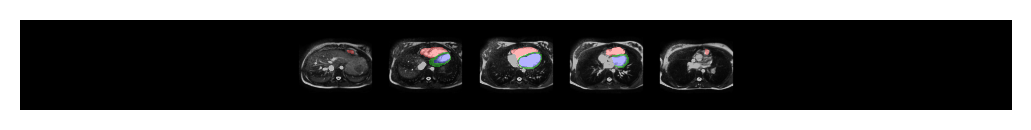

2020-12-03 07:37:24,924 INFO GT on AX


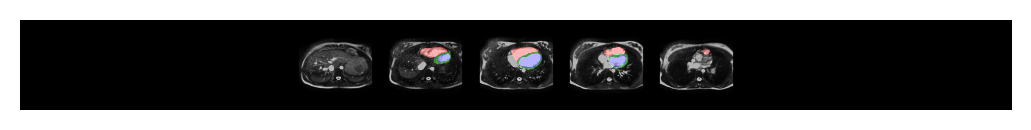

2020-12-03 07:37:25,420 INFO inv mask shape: (20, 288, 288, 4), gt mask shape: (20, 288, 288, 4)
2020-12-03 07:37:25,429 INFO DICE LV: 0.927611231803894
2020-12-03 07:37:25,435 INFO DICE RV: 0.9169211983680725
2020-12-03 07:37:25,442 INFO DICE MYO: 0.6930607557296753
2020-12-03 07:37:25,502 INFO m: [[ 0.5347  -0.8364   0.11835 -0.9927 ]
 [ 0.2993   0.3186   0.8994  -0.99   ]
 [-0.79    -0.4456   0.4207  10.39   ]]
2020-12-03 07:37:25,503 INFO m_mod: [[ 0.5347  -0.8364   0.11835 -0.4365 ]
 [ 0.2993   0.3186   0.8994  -0.3257 ]
 [-0.79    -0.4456   0.4207   0.4749 ]]
2020-12-03 07:37:25,503 INFO m_scaled: [[ 0.5347  -0.8364   0.11835 -0.873  ]
 [ 0.2993   0.3186   0.8994  -0.6514 ]
 [-0.79    -0.4456   0.4207   0.9497 ]]
2020-12-03 07:37:25,504 INFO 0000-11YU3CUF_2007-12-10_ES_msk.nrrd
2020-12-03 07:37:30,893 INFO DICE LV: 0.8451444506645203
2020-12-03 07:37:30,980 INFO DICE RV: 0.8270522952079773
2020-12-03 07:37:31,068 INFO DICE MYO: 0.725176215171814
2020-12-03 07:37:31,608 INFO Predi

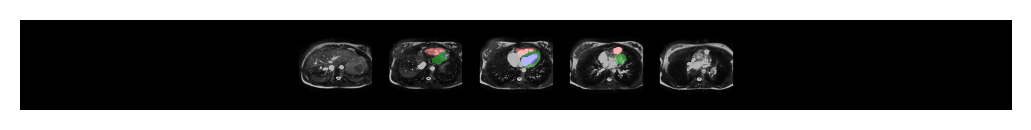

2020-12-03 07:37:32,033 INFO GT on AX


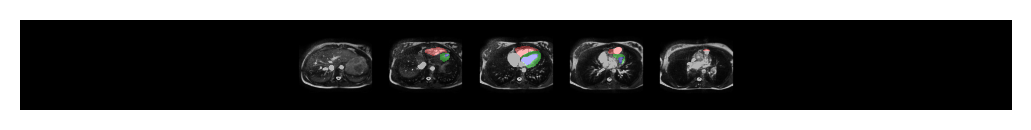

2020-12-03 07:37:32,527 INFO inv mask shape: (20, 288, 288, 4), gt mask shape: (20, 288, 288, 4)
2020-12-03 07:37:32,534 INFO DICE LV: 0.8445120453834534
2020-12-03 07:37:32,541 INFO DICE RV: 0.8373430967330933
2020-12-03 07:37:32,547 INFO DICE MYO: 0.7182096242904663
2020-12-03 07:37:32,608 INFO m: [[ 0.534  -0.8374  0.1158 -0.9927]
 [ 0.2996  0.3157  0.9004 -0.99  ]
 [-0.7905 -0.446   0.4194 10.42  ]]
2020-12-03 07:37:32,609 INFO m_mod: [[ 0.534  -0.8374  0.1158 -0.4375]
 [ 0.2996  0.3157  0.9004 -0.3267]
 [-0.7905 -0.446   0.4194  0.476 ]]
2020-12-03 07:37:32,609 INFO m_scaled: [[ 0.534  -0.8374  0.1158 -0.875 ]
 [ 0.2996  0.3157  0.9004 -0.6533]
 [-0.7905 -0.446   0.4194  0.952 ]]
2020-12-03 07:37:32,610 INFO 0000-1E8MCV9L_2005-12-15_ED_msk.nrrd
2020-12-03 07:37:37,892 INFO DICE LV: 0.8523464202880859
2020-12-03 07:37:37,980 INFO DICE RV: 0.8292949795722961
2020-12-03 07:37:38,067 INFO DICE MYO: 0.6298782825469971
2020-12-03 07:37:38,608 INFO Predicted mask rotated to AX on origina

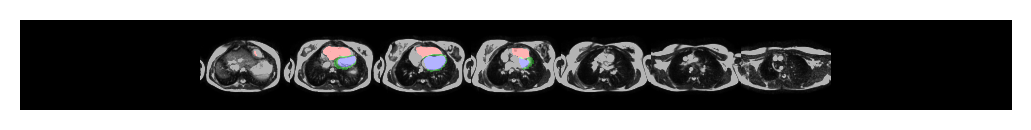

2020-12-03 07:37:39,029 INFO GT on AX


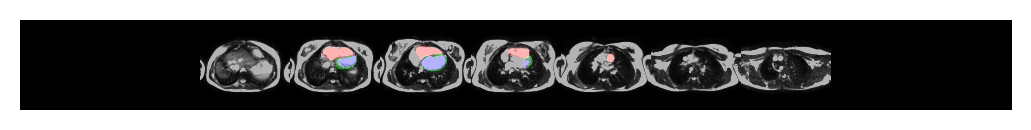

2020-12-03 07:37:39,604 INFO inv mask shape: (28, 256, 256, 4), gt mask shape: (28, 256, 256, 4)
2020-12-03 07:37:39,613 INFO DICE LV: 0.8316929936408997
2020-12-03 07:37:39,622 INFO DICE RV: 0.8377516269683838
2020-12-03 07:37:39,631 INFO DICE MYO: 0.6187129616737366
2020-12-03 07:37:39,694 INFO m: [[ 0.53    -0.8423   0.10144 -0.993  ]
 [ 0.301    0.2983   0.9062  -0.991  ]
 [-0.793   -0.4497   0.4116  10.6    ]]
2020-12-03 07:37:39,694 INFO m_mod: [[ 0.53    -0.8423   0.10144 -0.4434 ]
 [ 0.301    0.2983   0.9062  -0.3306 ]
 [-0.793   -0.4497   0.4116   0.4844 ]]
2020-12-03 07:37:39,695 INFO m_scaled: [[ 0.53    -0.8423   0.10144 -0.8867 ]
 [ 0.301    0.2983   0.9062  -0.661  ]
 [-0.793   -0.4497   0.4116   0.9688 ]]
2020-12-03 07:37:39,697 INFO 0000-1E8MCV9L_2005-12-15_ES_msk.nrrd
2020-12-03 07:37:44,958 INFO DICE LV: 0.7360267043113708
2020-12-03 07:37:45,044 INFO DICE RV: 0.5331363081932068
2020-12-03 07:37:45,130 INFO DICE MYO: 0.5774993896484375
2020-12-03 07:37:45,667 INFO Pre

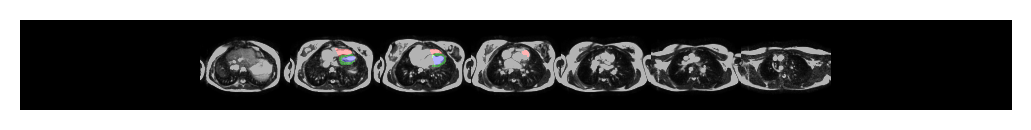

2020-12-03 07:37:46,084 INFO GT on AX


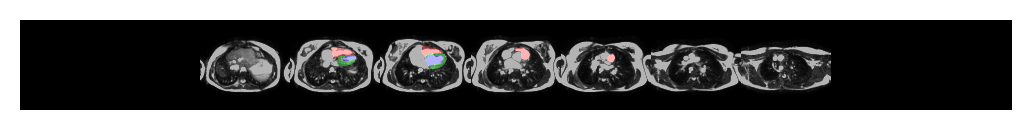

2020-12-03 07:37:46,653 INFO inv mask shape: (28, 256, 256, 4), gt mask shape: (28, 256, 256, 4)
2020-12-03 07:37:46,662 INFO DICE LV: 0.7134859561920166
2020-12-03 07:37:46,671 INFO DICE RV: 0.5031342506408691
2020-12-03 07:37:46,680 INFO DICE MYO: 0.5683603286743164
2020-12-03 07:37:46,738 INFO m: [[ 0.5303  -0.842    0.10236 -0.993  ]
 [ 0.3013   0.2996   0.906   -0.991  ]
 [-0.7925  -0.4495   0.4124  10.586  ]]
2020-12-03 07:37:46,739 INFO m_mod: [[ 0.5303  -0.842    0.10236 -0.4429 ]
 [ 0.3013   0.2996   0.906   -0.3306 ]
 [-0.7925  -0.4495   0.4124   0.484  ]]
2020-12-03 07:37:46,739 INFO m_scaled: [[ 0.5303  -0.842    0.10236 -0.8857 ]
 [ 0.3013   0.2996   0.906   -0.661  ]
 [-0.7925  -0.4495   0.4124   0.968  ]]
2020-12-03 07:37:46,742 INFO 0000-1PFT9CA1_2006-05-17_ED_msk.nrrd
2020-12-03 07:37:52,046 INFO DICE LV: 0.9140141010284424
2020-12-03 07:37:52,141 INFO DICE RV: 0.7667137980461121
2020-12-03 07:37:52,229 INFO DICE MYO: 0.6643645167350769
2020-12-03 07:37:52,765 INFO Pre

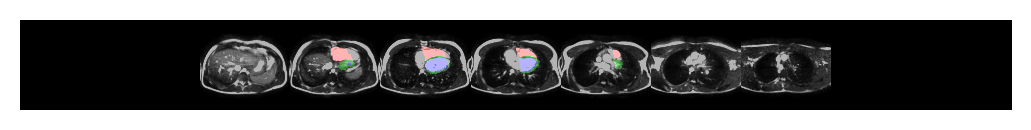

2020-12-03 07:37:53,198 INFO GT on AX


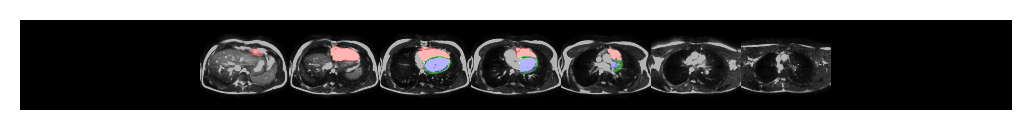

2020-12-03 07:37:53,794 INFO inv mask shape: (26, 256, 256, 4), gt mask shape: (26, 256, 256, 4)
2020-12-03 07:37:53,804 INFO DICE LV: 0.9211563467979431
2020-12-03 07:37:53,812 INFO DICE RV: 0.7778952121734619
2020-12-03 07:37:53,820 INFO DICE MYO: 0.6639246940612793
2020-12-03 07:37:53,885 INFO m: [[ 0.5386 -0.8315  0.1324 -0.992 ]
 [ 0.2979  0.3352  0.8936 -0.9897]
 [-0.788  -0.4421  0.4285 10.234 ]]
2020-12-03 07:37:53,885 INFO m_mod: [[ 0.5386 -0.8315  0.1324 -0.4316]
 [ 0.2979  0.3352  0.8936 -0.3218]
 [-0.788  -0.4421  0.4285  0.4678]]
2020-12-03 07:37:53,886 INFO m_scaled: [[ 0.5386 -0.8315  0.1324 -0.8633]
 [ 0.2979  0.3352  0.8936 -0.6436]
 [-0.788  -0.4421  0.4285  0.9355]]
2020-12-03 07:37:53,888 INFO 0000-1PFT9CA1_2006-05-17_ES_msk.nrrd
2020-12-03 07:38:00,248 INFO DICE LV: 0.8446786403656006
2020-12-03 07:38:00,337 INFO DICE RV: 0.6763419508934021
2020-12-03 07:38:00,426 INFO DICE MYO: 0.6196715831756592
2020-12-03 07:38:00,970 INFO Predicted mask rotated to AX on origina

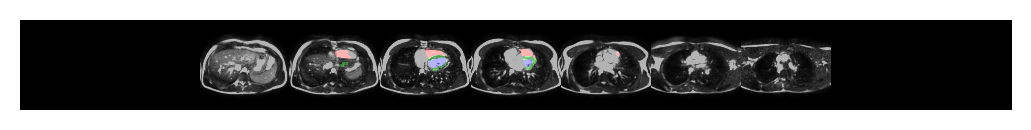

2020-12-03 07:38:01,404 INFO GT on AX


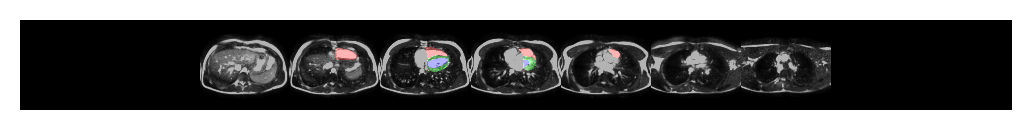

2020-12-03 07:38:02,017 INFO inv mask shape: (26, 256, 256, 4), gt mask shape: (26, 256, 256, 4)
2020-12-03 07:38:02,025 INFO DICE LV: 0.8621037006378174
2020-12-03 07:38:02,033 INFO DICE RV: 0.6814880967140198
2020-12-03 07:38:02,042 INFO DICE MYO: 0.6279268264770508
2020-12-03 07:38:02,106 INFO m: [[ 0.539  -0.831   0.1348 -0.9917]
 [ 0.2974  0.338   0.8926 -0.9893]
 [-0.7876 -0.4414  0.4294 10.21  ]]
2020-12-03 07:38:02,107 INFO m_mod: [[ 0.539  -0.831   0.1348 -0.4307]
 [ 0.2974  0.338   0.8926 -0.3208]
 [-0.7876 -0.4414  0.4294  0.4663]]
2020-12-03 07:38:02,107 INFO m_scaled: [[ 0.539  -0.831   0.1348 -0.8613]
 [ 0.2974  0.338   0.8926 -0.6416]
 [-0.7876 -0.4414  0.4294  0.9326]]
2020-12-03 07:38:02,110 INFO 0000-2V8HJLHN_2005-08-30_ED_msk.nrrd
2020-12-03 07:38:08,452 INFO DICE LV: 0.9206575155258179
2020-12-03 07:38:08,539 INFO DICE RV: 0.8412553071975708
2020-12-03 07:38:08,627 INFO DICE MYO: 0.6664213538169861
2020-12-03 07:38:09,166 INFO Predicted mask rotated to AX on origina

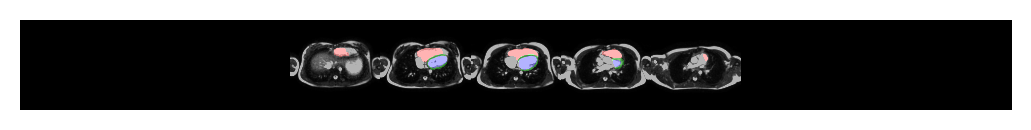

2020-12-03 07:38:09,593 INFO GT on AX


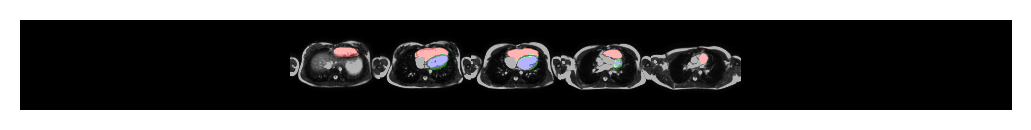

2020-12-03 07:38:10,134 INFO inv mask shape: (21, 256, 256, 4), gt mask shape: (21, 256, 256, 4)
2020-12-03 07:38:10,141 INFO DICE LV: 0.9301968216896057
2020-12-03 07:38:10,148 INFO DICE RV: 0.8417335748672485
2020-12-03 07:38:10,155 INFO DICE MYO: 0.6953799724578857
2020-12-03 07:38:10,216 INFO m: [[ 0.5435 -0.826   0.1488 -0.991 ]
 [ 0.2957  0.3542  0.887  -0.989 ]
 [-0.7856 -0.438   0.4368 10.04  ]]
2020-12-03 07:38:10,216 INFO m_mod: [[ 0.5435 -0.826   0.1488 -0.4253]
 [ 0.2957  0.3542  0.887  -0.317 ]
 [-0.7856 -0.438   0.4368  0.4587]]
2020-12-03 07:38:10,217 INFO m_scaled: [[ 0.5435 -0.826   0.1488 -0.8506]
 [ 0.2957  0.3542  0.887  -0.634 ]
 [-0.7856 -0.438   0.4368  0.9175]]
2020-12-03 07:38:10,219 INFO 0000-2V8HJLHN_2005-08-30_ES_msk.nrrd
2020-12-03 07:38:15,502 INFO DICE LV: 0.8330525755882263
2020-12-03 07:38:15,591 INFO DICE RV: 0.767723023891449
2020-12-03 07:38:15,681 INFO DICE MYO: 0.6692377924919128
2020-12-03 07:38:16,226 INFO Predicted mask rotated to AX on original

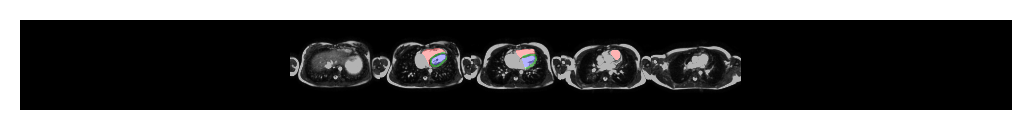

2020-12-03 07:38:16,658 INFO GT on AX


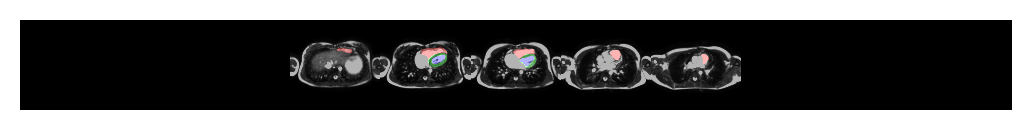

2020-12-03 07:38:17,183 INFO inv mask shape: (21, 256, 256, 4), gt mask shape: (21, 256, 256, 4)
2020-12-03 07:38:17,190 INFO DICE LV: 0.8534657955169678
2020-12-03 07:38:17,197 INFO DICE RV: 0.7610220909118652
2020-12-03 07:38:17,203 INFO DICE MYO: 0.6930665969848633
2020-12-03 07:38:17,267 INFO m: [[ 0.5405 -0.83    0.1388 -0.9917]
 [ 0.2969  0.3425  0.891  -0.9893]
 [-0.787  -0.4404  0.4314 10.164 ]]
2020-12-03 07:38:17,268 INFO m_mod: [[ 0.5405 -0.83    0.1388 -0.4292]
 [ 0.2969  0.3425  0.891  -0.3198]
 [-0.787  -0.4404  0.4314  0.4644]]
2020-12-03 07:38:17,268 INFO m_scaled: [[ 0.5405 -0.83    0.1388 -0.8584]
 [ 0.2969  0.3425  0.891  -0.6396]
 [-0.787  -0.4404  0.4314  0.9287]]
2020-12-03 07:38:17,272 INFO 0000-2WHFP73X_2007-03-28_ED_msk.nrrd
2020-12-03 07:38:23,600 INFO DICE LV: 0.8915466666221619
2020-12-03 07:38:23,701 INFO DICE RV: 0.7768818736076355
2020-12-03 07:38:23,789 INFO DICE MYO: 0.6851637959480286
2020-12-03 07:38:24,345 INFO Predicted mask rotated to AX on origina

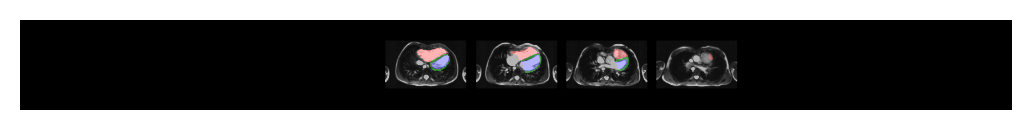

2020-12-03 07:38:24,765 INFO GT on AX


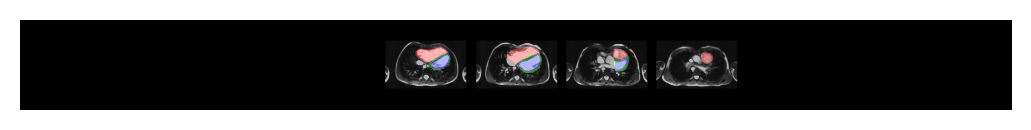

2020-12-03 07:38:25,190 INFO inv mask shape: (17, 114, 192, 4), gt mask shape: (17, 114, 192, 4)
2020-12-03 07:38:25,193 INFO DICE LV: 0.8994793891906738
2020-12-03 07:38:25,196 INFO DICE RV: 0.7832666635513306
2020-12-03 07:38:25,199 INFO DICE MYO: 0.6935526728630066
2020-12-03 07:38:25,262 INFO m: [[ 0.5493 -0.819   0.1667 -0.99  ]
 [ 0.294   0.3762  0.879  -0.9873]
 [-0.782  -0.4338  0.4473  9.83  ]]
2020-12-03 07:38:25,262 INFO m_mod: [[ 0.5493 -0.819   0.1667 -0.4185]
 [ 0.294   0.3762  0.879  -0.3115]
 [-0.782  -0.4338  0.4473  0.449 ]]
2020-12-03 07:38:25,263 INFO m_scaled: [[ 0.5493 -0.819   0.1667 -0.837 ]
 [ 0.294   0.3762  0.879  -0.623 ]
 [-0.782  -0.4338  0.4473  0.898 ]]
2020-12-03 07:38:25,264 INFO 0000-2WHFP73X_2007-03-28_ES_msk.nrrd
2020-12-03 07:38:30,509 INFO DICE LV: 0.7393097281455994
2020-12-03 07:38:30,602 INFO DICE RV: 0.4373246133327484
2020-12-03 07:38:30,688 INFO DICE MYO: 0.6114866733551025
2020-12-03 07:38:31,237 INFO Predicted mask rotated to AX on origina

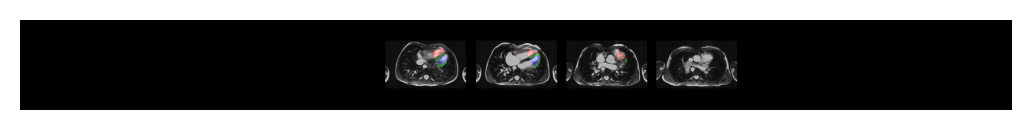

2020-12-03 07:38:31,655 INFO GT on AX


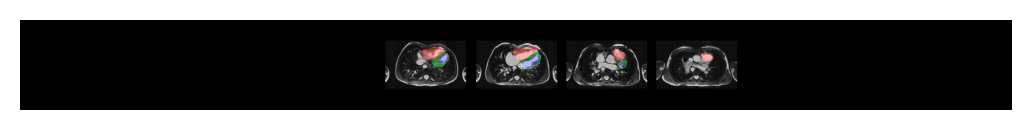

2020-12-03 07:38:32,070 INFO inv mask shape: (17, 114, 192, 4), gt mask shape: (17, 114, 192, 4)
2020-12-03 07:38:32,074 INFO DICE LV: 0.7272007465362549
2020-12-03 07:38:32,077 INFO DICE RV: 0.42049264907836914
2020-12-03 07:38:32,080 INFO DICE MYO: 0.5712959170341492
2020-12-03 07:38:32,139 INFO m: [[ 0.546  -0.823   0.1562 -0.9907]
 [ 0.2952  0.3633  0.884  -0.9883]
 [-0.784  -0.4363  0.4412  9.95  ]]
2020-12-03 07:38:32,139 INFO m_mod: [[ 0.546  -0.823   0.1562 -0.4229]
 [ 0.2952  0.3633  0.884  -0.315 ]
 [-0.784  -0.4363  0.4412  0.4548]]
2020-12-03 07:38:32,140 INFO m_scaled: [[ 0.546  -0.823   0.1562 -0.8457]
 [ 0.2952  0.3633  0.884  -0.63  ]
 [-0.784  -0.4363  0.4412  0.9097]]
2020-12-03 07:38:32,141 INFO 0000-44U3AGET_2006-08-01_ED_msk.nrrd
2020-12-03 07:38:38,420 INFO DICE LV: 0.8265830278396606
2020-12-03 07:38:38,515 INFO DICE RV: 0.6913983225822449
2020-12-03 07:38:38,609 INFO DICE MYO: 0.5661330223083496
2020-12-03 07:38:39,156 INFO Predicted mask rotated to AX on origin

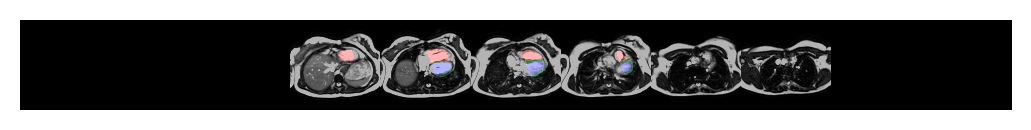

2020-12-03 07:38:39,598 INFO GT on AX


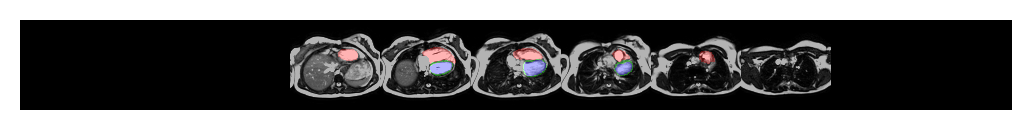

2020-12-03 07:38:40,163 INFO inv mask shape: (22, 256, 256, 4), gt mask shape: (22, 256, 256, 4)
2020-12-03 07:38:40,172 INFO DICE LV: 0.839407205581665
2020-12-03 07:38:40,179 INFO DICE RV: 0.7015751004219055
2020-12-03 07:38:40,186 INFO DICE MYO: 0.5750980377197266
2020-12-03 07:38:40,246 INFO m: [[ 0.533   -0.838    0.11365 -0.9927 ]
 [ 0.2998   0.313    0.901   -0.9907 ]
 [-0.791   -0.4463   0.4182  10.46   ]]
2020-12-03 07:38:40,247 INFO m_mod: [[ 0.533   -0.838    0.11365 -0.439  ]
 [ 0.2998   0.313    0.901   -0.3271 ]
 [-0.791   -0.4463   0.4182   0.4778 ]]
2020-12-03 07:38:40,247 INFO m_scaled: [[ 0.533   -0.838    0.11365 -0.878  ]
 [ 0.2998   0.313    0.901   -0.6543 ]
 [-0.791   -0.4463   0.4182   0.9556 ]]
2020-12-03 07:38:40,248 INFO 0000-44U3AGET_2006-08-01_ES_msk.nrrd
2020-12-03 07:38:48,903 INFO DICE LV: 0.8028969168663025
2020-12-03 07:38:48,980 INFO DICE RV: 0.631452202796936
2020-12-03 07:38:49,056 INFO DICE MYO: 0.5657995939254761
2020-12-03 07:38:49,576 INFO Predi

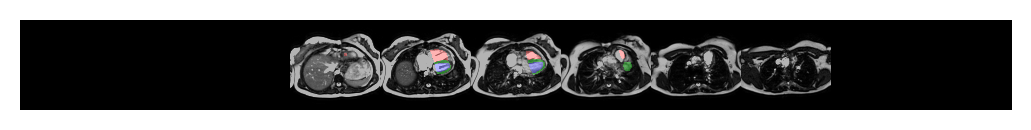

2020-12-03 07:38:50,009 INFO GT on AX


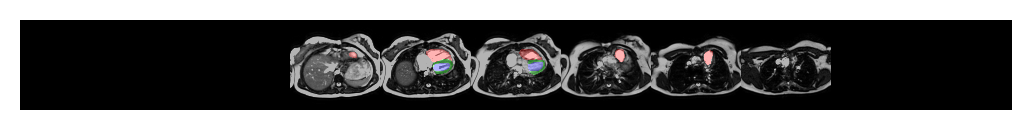

2020-12-03 07:38:50,513 INFO inv mask shape: (22, 256, 256, 4), gt mask shape: (22, 256, 256, 4)
2020-12-03 07:38:50,519 INFO DICE LV: 0.7981386780738831
2020-12-03 07:38:50,524 INFO DICE RV: 0.6364691853523254
2020-12-03 07:38:50,530 INFO DICE MYO: 0.5668755173683167
2020-12-03 07:38:50,583 INFO m: [[ 0.533  -0.839   0.1131 -0.9927]
 [ 0.3     0.3125  0.9014 -0.9907]
 [-0.791  -0.4465  0.4182 10.46  ]]
2020-12-03 07:38:50,584 INFO m_mod: [[ 0.533  -0.839   0.1131 -0.439 ]
 [ 0.3     0.3125  0.9014 -0.3271]
 [-0.791  -0.4465  0.4182  0.478 ]]
2020-12-03 07:38:50,585 INFO m_scaled: [[ 0.533  -0.839   0.1131 -0.878 ]
 [ 0.3     0.3125  0.9014 -0.6543]
 [-0.791  -0.4465  0.4182  0.956 ]]
2020-12-03 07:38:50,586 INFO 0000-49RHVC6C_2005-11-22_ED_msk.nrrd
2020-12-03 07:38:55,894 INFO DICE LV: 0.9314835071563721
2020-12-03 07:38:55,967 INFO DICE RV: 0.86662358045578
2020-12-03 07:38:56,040 INFO DICE MYO: 0.6547006368637085
2020-12-03 07:38:56,562 INFO Predicted mask rotated to AX on original 

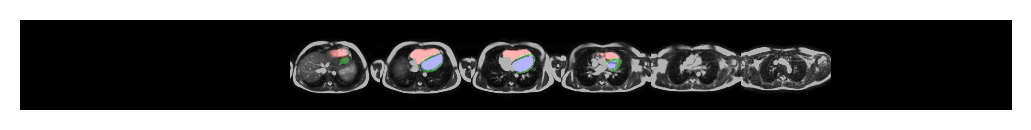

2020-12-03 07:38:57,012 INFO GT on AX


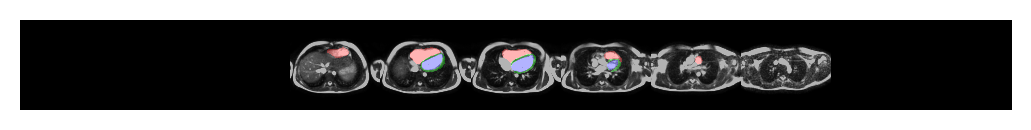

2020-12-03 07:38:57,514 INFO inv mask shape: (22, 256, 256, 4), gt mask shape: (22, 256, 256, 4)
2020-12-03 07:38:57,520 INFO DICE LV: 0.9336869120597839
2020-12-03 07:38:57,526 INFO DICE RV: 0.8700135350227356
2020-12-03 07:38:57,532 INFO DICE MYO: 0.6741524934768677
2020-12-03 07:38:57,577 INFO m: [[ 0.539  -0.8306  0.135  -0.9917]
 [ 0.2974  0.3386  0.8926 -0.9893]
 [-0.7876 -0.4412  0.4297 10.21  ]]
2020-12-03 07:38:57,578 INFO m_mod: [[ 0.539  -0.8306  0.135  -0.4307]
 [ 0.2974  0.3386  0.8926 -0.3208]
 [-0.7876 -0.4412  0.4297  0.4666]]
2020-12-03 07:38:57,578 INFO m_scaled: [[ 0.539  -0.8306  0.135  -0.8613]
 [ 0.2974  0.3386  0.8926 -0.6416]
 [-0.7876 -0.4412  0.4297  0.933 ]]
2020-12-03 07:38:57,579 INFO 0000-49RHVC6C_2005-11-22_ES_msk.nrrd
2020-12-03 07:39:02,874 INFO DICE LV: 0.843416690826416
2020-12-03 07:39:02,955 INFO DICE RV: 0.7092302441596985
2020-12-03 07:39:03,036 INFO DICE MYO: 0.6695191264152527
2020-12-03 07:39:03,549 INFO Predicted mask rotated to AX on original

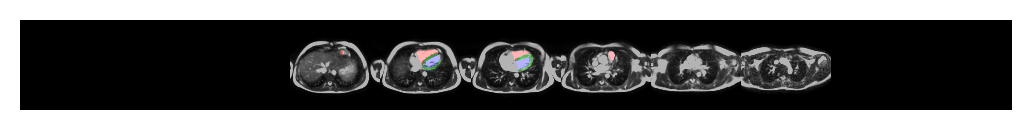

2020-12-03 07:39:03,979 INFO GT on AX


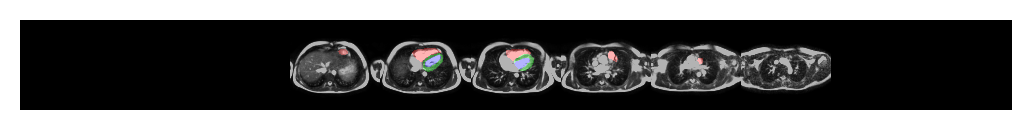

2020-12-03 07:39:04,483 INFO inv mask shape: (22, 256, 256, 4), gt mask shape: (22, 256, 256, 4)
2020-12-03 07:39:04,489 INFO DICE LV: 0.8559454679489136
2020-12-03 07:39:04,495 INFO DICE RV: 0.7144820094108582
2020-12-03 07:39:04,501 INFO DICE MYO: 0.6818028688430786
2020-12-03 07:39:04,553 INFO m: [[ 0.5386 -0.8315  0.1324 -0.992 ]
 [ 0.2979  0.3352  0.8936 -0.9897]
 [-0.788  -0.4421  0.4285 10.234 ]]
2020-12-03 07:39:04,554 INFO m_mod: [[ 0.5386 -0.8315  0.1324 -0.4316]
 [ 0.2979  0.3352  0.8936 -0.3218]
 [-0.788  -0.4421  0.4285  0.4678]]
2020-12-03 07:39:04,554 INFO m_scaled: [[ 0.5386 -0.8315  0.1324 -0.8633]
 [ 0.2979  0.3352  0.8936 -0.6436]
 [-0.788  -0.4421  0.4285  0.9355]]
2020-12-03 07:39:04,555 INFO 0000-76RJ3Z26_2006-11-23_ED_msk.nrrd
2020-12-03 07:39:09,814 INFO DICE LV: 0.7798845767974854
2020-12-03 07:39:09,888 INFO DICE RV: 0.7018373608589172
2020-12-03 07:39:09,960 INFO DICE MYO: 0.5296518206596375
2020-12-03 07:39:10,501 INFO Predicted mask rotated to AX on origina

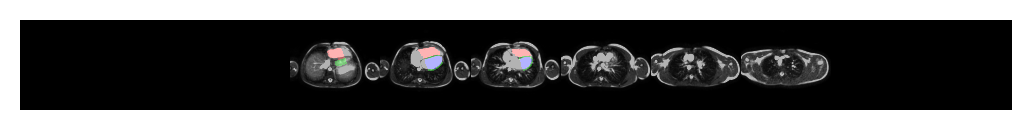

2020-12-03 07:39:10,932 INFO GT on AX


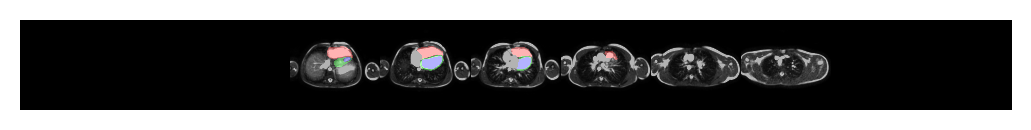

2020-12-03 07:39:11,455 INFO inv mask shape: (24, 256, 256, 4), gt mask shape: (24, 256, 256, 4)
2020-12-03 07:39:11,464 INFO DICE LV: 0.745428740978241
2020-12-03 07:39:11,472 INFO DICE RV: 0.7500553727149963
2020-12-03 07:39:11,480 INFO DICE MYO: 0.4817313551902771
2020-12-03 07:39:11,524 INFO m: [[ 0.542  -0.828   0.1445 -0.9917]
 [ 0.2961  0.3494  0.889  -0.989 ]
 [-0.786  -0.4392  0.4346 10.09  ]]
2020-12-03 07:39:11,525 INFO m_mod: [[ 0.542  -0.828   0.1445 -0.4272]
 [ 0.2961  0.3494  0.889  -0.3184]
 [-0.786  -0.4392  0.4346  0.4612]]
2020-12-03 07:39:11,526 INFO m_scaled: [[ 0.542  -0.828   0.1445 -0.8545]
 [ 0.2961  0.3494  0.889  -0.6367]
 [-0.786  -0.4392  0.4346  0.9224]]
2020-12-03 07:39:11,526 INFO 0000-76RJ3Z26_2006-11-23_ES_msk.nrrd
2020-12-03 07:39:16,757 INFO DICE LV: 0.838394284248352
2020-12-03 07:39:16,837 INFO DICE RV: 0.6183673739433289
2020-12-03 07:39:16,916 INFO DICE MYO: 0.6413187980651855
2020-12-03 07:39:17,441 INFO Predicted mask rotated to AX on original 

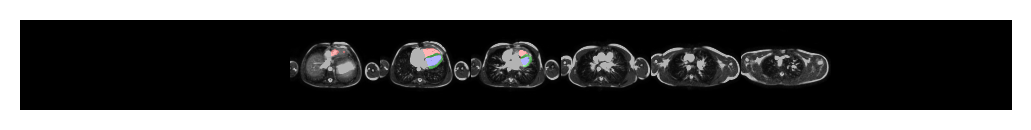

2020-12-03 07:39:17,885 INFO GT on AX


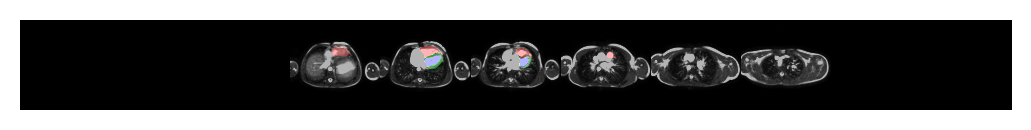

2020-12-03 07:39:18,399 INFO inv mask shape: (24, 256, 256, 4), gt mask shape: (24, 256, 256, 4)
2020-12-03 07:39:18,407 INFO DICE LV: 0.8582696318626404
2020-12-03 07:39:18,414 INFO DICE RV: 0.6287960410118103
2020-12-03 07:39:18,422 INFO DICE MYO: 0.662208616733551
2020-12-03 07:39:18,474 INFO m: [[ 0.5425 -0.827   0.1454 -0.991 ]
 [ 0.2964  0.35    0.8887 -0.989 ]
 [-0.786  -0.439   0.4353 10.08  ]]
2020-12-03 07:39:18,474 INFO m_mod: [[ 0.5425 -0.827   0.1454 -0.4268]
 [ 0.2964  0.35    0.8887 -0.3179]
 [-0.786  -0.439   0.4353  0.4604]]
2020-12-03 07:39:18,475 INFO m_scaled: [[ 0.5425 -0.827   0.1454 -0.8535]
 [ 0.2964  0.35    0.8887 -0.6357]
 [-0.786  -0.439   0.4353  0.921 ]]
2020-12-03 07:39:18,476 INFO 0000-8J5NZ5G7_2008-03-27_ED_msk.nrrd
2020-12-03 07:39:23,684 INFO DICE LV: 0.8892917037010193
2020-12-03 07:39:23,757 INFO DICE RV: 0.8129462599754333
2020-12-03 07:39:23,830 INFO DICE MYO: 0.6104961037635803
2020-12-03 07:39:24,342 INFO Predicted mask rotated to AX on original

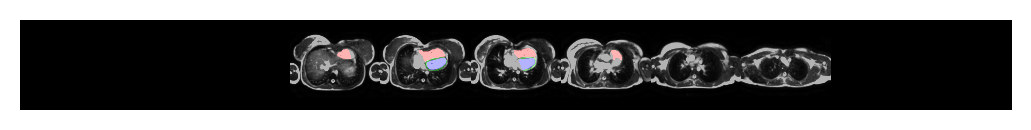

2020-12-03 07:39:24,761 INFO GT on AX


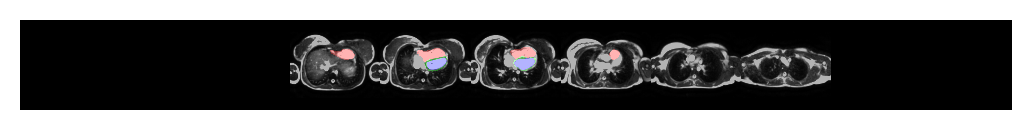

2020-12-03 07:39:25,261 INFO inv mask shape: (24, 256, 256, 4), gt mask shape: (24, 256, 256, 4)
2020-12-03 07:39:25,269 INFO DICE LV: 0.9039133191108704
2020-12-03 07:39:25,276 INFO DICE RV: 0.8134686350822449
2020-12-03 07:39:25,283 INFO DICE MYO: 0.6311294436454773
2020-12-03 07:39:25,329 INFO m: [[ 0.5205  -0.852    0.06415 -0.9946 ]
 [ 0.305    0.2551   0.918   -0.9927 ]
 [-0.798   -0.4578   0.3926  11.016  ]]
2020-12-03 07:39:25,330 INFO m_mod: [[ 0.5205  -0.852    0.06415 -0.456  ]
 [ 0.305    0.2551   0.918   -0.3413 ]
 [-0.798   -0.4578   0.3926   0.5034 ]]
2020-12-03 07:39:25,330 INFO m_scaled: [[ 0.5205  -0.852    0.06415 -0.912  ]
 [ 0.305    0.2551   0.918   -0.6826 ]
 [-0.798   -0.4578   0.3926   1.007  ]]
2020-12-03 07:39:25,331 INFO 0000-8J5NZ5G7_2008-03-27_ES_msk.nrrd
2020-12-03 07:39:30,512 INFO DICE LV: 0.8703469634056091
2020-12-03 07:39:30,606 INFO DICE RV: 0.7750486731529236
2020-12-03 07:39:30,692 INFO DICE MYO: 0.6953973174095154
2020-12-03 07:39:31,223 INFO Pre

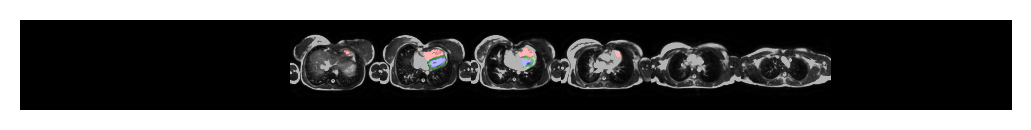

2020-12-03 07:39:31,644 INFO GT on AX


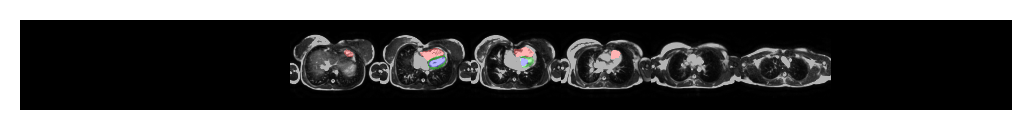

2020-12-03 07:39:32,212 INFO inv mask shape: (24, 256, 256, 4), gt mask shape: (24, 256, 256, 4)
2020-12-03 07:39:32,221 INFO DICE LV: 0.8854424357414246
2020-12-03 07:39:32,228 INFO DICE RV: 0.7654315233230591
2020-12-03 07:39:32,236 INFO DICE MYO: 0.7222899198532104
2020-12-03 07:39:32,296 INFO m: [[ 0.5225 -0.8496  0.0722 -0.994 ]
 [ 0.3042  0.2651  0.915  -0.992 ]
 [-0.7964 -0.456   0.397  10.914 ]]
2020-12-03 07:39:32,296 INFO m_mod: [[ 0.5225 -0.8496  0.0722 -0.4526]
 [ 0.3042  0.2651  0.915  -0.3389]
 [-0.7964 -0.456   0.397   0.4988]]
2020-12-03 07:39:32,297 INFO m_scaled: [[ 0.5225 -0.8496  0.0722 -0.9053]
 [ 0.3042  0.2651  0.915  -0.6777]
 [-0.7964 -0.456   0.397   0.9976]]
2020-12-03 07:39:32,298 INFO 0000-9A8UTCZ4_2007-03-16_ED_msk.nrrd
2020-12-03 07:39:37,394 INFO DICE LV: 0.9027015566825867
2020-12-03 07:39:37,481 INFO DICE RV: 0.8654681444168091
2020-12-03 07:39:37,568 INFO DICE MYO: 0.6480990052223206
2020-12-03 07:39:38,110 INFO Predicted mask rotated to AX on origina

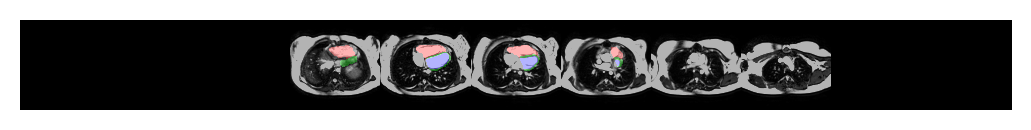

2020-12-03 07:39:38,529 INFO GT on AX


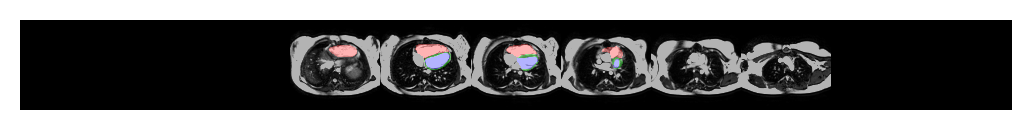

2020-12-03 07:39:39,086 INFO inv mask shape: (22, 256, 256, 4), gt mask shape: (22, 256, 256, 4)
2020-12-03 07:39:39,094 INFO DICE LV: 0.902759850025177
2020-12-03 07:39:39,100 INFO DICE RV: 0.8786508440971375
2020-12-03 07:39:39,108 INFO DICE MYO: 0.6328360438346863
2020-12-03 07:39:39,167 INFO m: [[ 0.519   -0.8525   0.06024 -0.9946 ]
 [ 0.3054   0.2507   0.9185  -0.9927 ]
 [-0.7983  -0.4587   0.3906  11.08   ]]
2020-12-03 07:39:39,168 INFO m_mod: [[ 0.519   -0.8525   0.06024 -0.458  ]
 [ 0.3054   0.2507   0.9185  -0.3423 ]
 [-0.7983  -0.4587   0.3906   0.506  ]]
2020-12-03 07:39:39,168 INFO m_scaled: [[ 0.519   -0.8525   0.06024 -0.916  ]
 [ 0.3054   0.2507   0.9185  -0.6846 ]
 [-0.7983  -0.4587   0.3906   1.012  ]]
2020-12-03 07:39:39,169 INFO 0000-9A8UTCZ4_2007-03-16_ES_msk.nrrd
2020-12-03 07:39:44,368 INFO DICE LV: 0.8452568650245667
2020-12-03 07:39:44,468 INFO DICE RV: 0.6752605438232422
2020-12-03 07:39:44,555 INFO DICE MYO: 0.6855459809303284
2020-12-03 07:39:45,102 INFO Pred

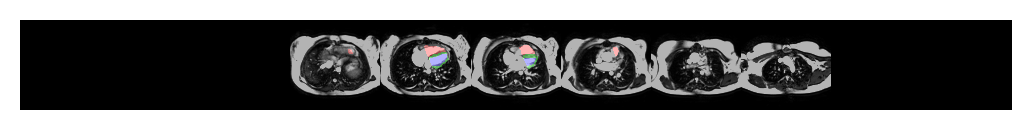

2020-12-03 07:39:45,530 INFO GT on AX


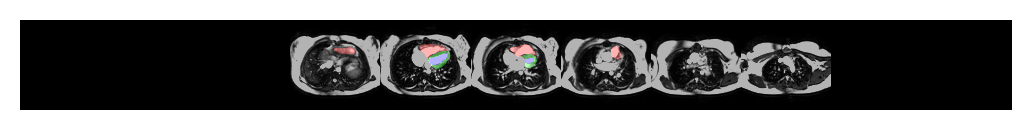

2020-12-03 07:39:46,077 INFO inv mask shape: (22, 256, 256, 4), gt mask shape: (22, 256, 256, 4)
2020-12-03 07:39:46,084 INFO DICE LV: 0.8505910038948059
2020-12-03 07:39:46,091 INFO DICE RV: 0.6915433406829834
2020-12-03 07:39:46,099 INFO DICE MYO: 0.6809178590774536
2020-12-03 07:39:46,160 INFO m: [[ 0.521  -0.851   0.0674 -0.9946]
 [ 0.3047  0.259   0.917  -0.9927]
 [-0.7974 -0.457   0.3943 11.    ]]
2020-12-03 07:39:46,161 INFO m_mod: [[ 0.521  -0.851   0.0674 -0.4556]
 [ 0.3047  0.259   0.917  -0.3403]
 [-0.7974 -0.457   0.3943  0.5024]]
2020-12-03 07:39:46,161 INFO m_scaled: [[ 0.521  -0.851   0.0674 -0.911 ]
 [ 0.3047  0.259   0.917  -0.6807]
 [-0.7974 -0.457   0.3943  1.005 ]]
2020-12-03 07:39:46,162 INFO 0000-9MTQG5XR_2005-05-23_ED_msk.nrrd
2020-12-03 07:39:51,436 INFO DICE LV: 0.9023810029029846
2020-12-03 07:39:51,524 INFO DICE RV: 0.8073644042015076
2020-12-03 07:39:51,612 INFO DICE MYO: 0.643060028553009
2020-12-03 07:39:52,156 INFO Predicted mask rotated to AX on original

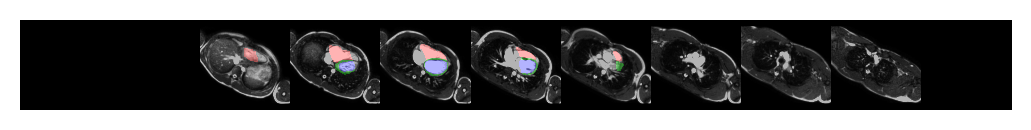

2020-12-03 07:39:52,586 INFO GT on AX


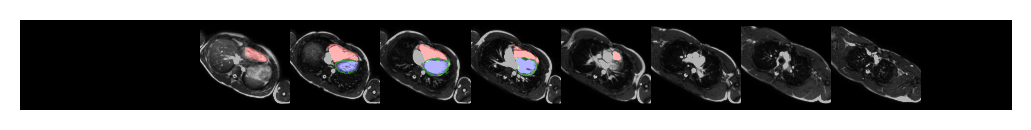

2020-12-03 07:39:53,132 INFO inv mask shape: (20, 256, 256, 4), gt mask shape: (20, 256, 256, 4)
2020-12-03 07:39:53,140 INFO DICE LV: 0.9017083048820496
2020-12-03 07:39:53,146 INFO DICE RV: 0.8118820190429688
2020-12-03 07:39:53,152 INFO DICE MYO: 0.6420071125030518
2020-12-03 07:39:53,214 INFO m: [[ 0.537  -0.834   0.1262 -0.992 ]
 [ 0.2983  0.328   0.8965 -0.9897]
 [-0.789  -0.4436  0.425  10.3   ]]
2020-12-03 07:39:53,215 INFO m_mod: [[ 0.537  -0.834   0.1262 -0.4336]
 [ 0.2983  0.328   0.8965 -0.3237]
 [-0.789  -0.4436  0.425   0.4705]]
2020-12-03 07:39:53,215 INFO m_scaled: [[ 0.537  -0.834   0.1262 -0.867 ]
 [ 0.2983  0.328   0.8965 -0.6475]
 [-0.789  -0.4436  0.425   0.941 ]]
2020-12-03 07:39:53,216 INFO 0000-9MTQG5XR_2005-05-23_ES_msk.nrrd
2020-12-03 07:39:58,420 INFO DICE LV: 0.850928008556366
2020-12-03 07:39:58,514 INFO DICE RV: 0.774490237236023
2020-12-03 07:39:58,601 INFO DICE MYO: 0.7064115405082703
2020-12-03 07:39:59,147 INFO Predicted mask rotated to AX on original 

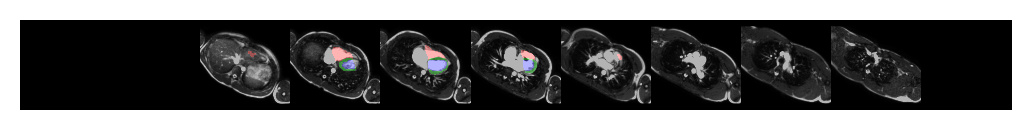

2020-12-03 07:39:59,576 INFO GT on AX


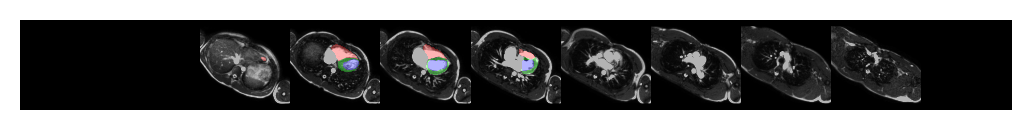

2020-12-03 07:40:00,169 INFO inv mask shape: (20, 256, 256, 4), gt mask shape: (20, 256, 256, 4)
2020-12-03 07:40:00,176 INFO DICE LV: 0.8446115255355835
2020-12-03 07:40:00,183 INFO DICE RV: 0.7746222615242004
2020-12-03 07:40:00,189 INFO DICE MYO: 0.7037656903266907
2020-12-03 07:40:00,252 INFO m: [[ 0.5356 -0.8364  0.1197 -0.9927]
 [ 0.2993  0.3203  0.899  -0.99  ]
 [-0.79   -0.4453  0.4216 10.37  ]]
2020-12-03 07:40:00,252 INFO m_mod: [[ 0.5356 -0.8364  0.1197 -0.4355]
 [ 0.2993  0.3203  0.899  -0.3252]
 [-0.79   -0.4453  0.4216  0.4739]]
2020-12-03 07:40:00,253 INFO m_scaled: [[ 0.5356 -0.8364  0.1197 -0.871 ]
 [ 0.2993  0.3203  0.899  -0.6504]
 [-0.79   -0.4453  0.4216  0.9478]]
2020-12-03 07:40:00,254 INFO 0000-CKFQTQ9F_2006-11-10_ED_msk.nrrd
2020-12-03 07:40:05,491 INFO DICE LV: 0.921968400478363
2020-12-03 07:40:05,582 INFO DICE RV: 0.8563011884689331
2020-12-03 07:40:05,671 INFO DICE MYO: 0.7098361849784851
2020-12-03 07:40:06,252 INFO Predicted mask rotated to AX on original

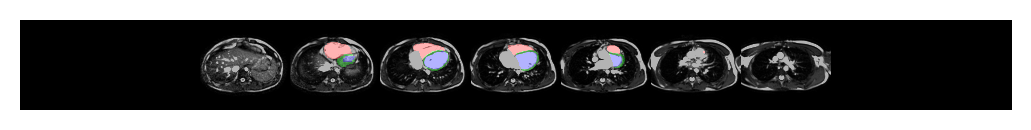

2020-12-03 07:40:06,686 INFO GT on AX


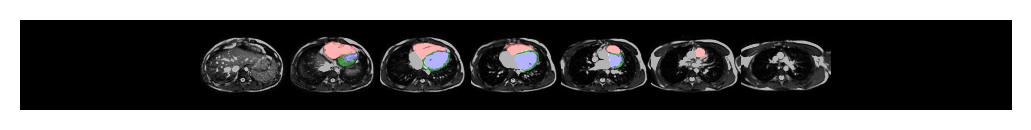

2020-12-03 07:40:07,262 INFO inv mask shape: (25, 256, 256, 4), gt mask shape: (25, 256, 256, 4)
2020-12-03 07:40:07,271 INFO DICE LV: 0.9288107752799988
2020-12-03 07:40:07,279 INFO DICE RV: 0.8639256358146667
2020-12-03 07:40:07,286 INFO DICE MYO: 0.707446813583374
2020-12-03 07:40:07,348 INFO m: [[ 0.5303 -0.842   0.1019 -0.993 ]
 [ 0.3013  0.2993  0.9053 -0.991 ]
 [-0.7925 -0.4495  0.412  10.586 ]]
2020-12-03 07:40:07,348 INFO m_mod: [[ 0.5303 -0.842   0.1019 -0.4429]
 [ 0.3013  0.2993  0.9053 -0.3306]
 [-0.7925 -0.4495  0.412   0.4836]]
2020-12-03 07:40:07,349 INFO m_scaled: [[ 0.5303 -0.842   0.1019 -0.8857]
 [ 0.3013  0.2993  0.9053 -0.661 ]
 [-0.7925 -0.4495  0.412   0.9673]]
2020-12-03 07:40:07,350 INFO 0000-CKFQTQ9F_2006-11-10_ES_msk.nrrd
2020-12-03 07:40:12,613 INFO DICE LV: 0.8597858548164368
2020-12-03 07:40:12,700 INFO DICE RV: 0.7740143537521362
2020-12-03 07:40:12,786 INFO DICE MYO: 0.7464061975479126
2020-12-03 07:40:13,332 INFO Predicted mask rotated to AX on original

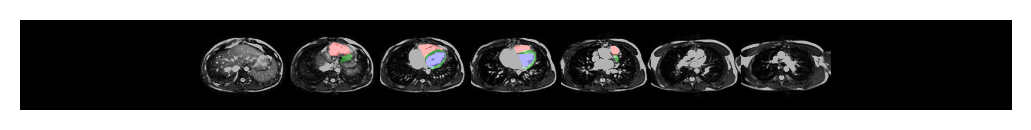

2020-12-03 07:40:13,753 INFO GT on AX


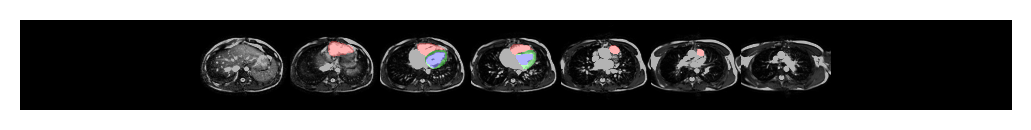

2020-12-03 07:40:14,303 INFO inv mask shape: (25, 256, 256, 4), gt mask shape: (25, 256, 256, 4)
2020-12-03 07:40:14,311 INFO DICE LV: 0.8579850196838379
2020-12-03 07:40:14,318 INFO DICE RV: 0.7788925170898438
2020-12-03 07:40:14,326 INFO DICE MYO: 0.7359439134597778
2020-12-03 07:40:14,386 INFO m: [[ 0.527  -0.8457  0.089  -0.9937]
 [ 0.3025  0.2842  0.9097 -0.9917]
 [-0.7944 -0.4524  0.4055 10.73  ]]
2020-12-03 07:40:14,386 INFO m_mod: [[ 0.527  -0.8457  0.089  -0.4473]
 [ 0.3025  0.2842  0.9097 -0.334 ]
 [-0.7944 -0.4524  0.4055  0.4902]]
2020-12-03 07:40:14,387 INFO m_scaled: [[ 0.527  -0.8457  0.089  -0.8945]
 [ 0.3025  0.2842  0.9097 -0.668 ]
 [-0.7944 -0.4524  0.4055  0.9805]]
2020-12-03 07:40:14,388 INFO 0000-CUKYUVC2_2006-09-20_ED_msk.nrrd
2020-12-03 07:40:20,634 INFO DICE LV: 0.8875682353973389
2020-12-03 07:40:20,730 INFO DICE RV: 0.8542386889457703
2020-12-03 07:40:20,824 INFO DICE MYO: 0.6360659599304199
2020-12-03 07:40:21,372 INFO Predicted mask rotated to AX on origina

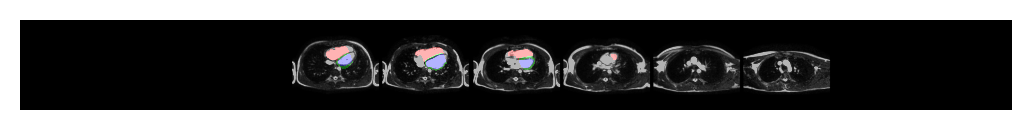

2020-12-03 07:40:21,805 INFO GT on AX


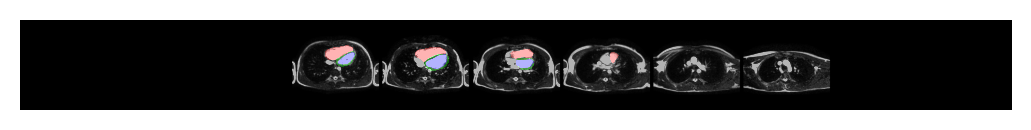

2020-12-03 07:40:22,373 INFO inv mask shape: (24, 256, 256, 4), gt mask shape: (24, 256, 256, 4)
2020-12-03 07:40:22,381 INFO DICE LV: 0.8901257514953613
2020-12-03 07:40:22,388 INFO DICE RV: 0.8541207909584045
2020-12-03 07:40:22,396 INFO DICE MYO: 0.6544090509414673
2020-12-03 07:40:22,456 INFO m: [[ 0.542  -0.828   0.1445 -0.9917]
 [ 0.2961  0.3494  0.889  -0.989 ]
 [-0.786  -0.4392  0.4346 10.09  ]]
2020-12-03 07:40:22,456 INFO m_mod: [[ 0.542  -0.828   0.1445 -0.4272]
 [ 0.2961  0.3494  0.889  -0.3184]
 [-0.786  -0.4392  0.4346  0.4614]]
2020-12-03 07:40:22,457 INFO m_scaled: [[ 0.542  -0.828   0.1445 -0.8545]
 [ 0.2961  0.3494  0.889  -0.6367]
 [-0.786  -0.4392  0.4346  0.923 ]]
2020-12-03 07:40:22,458 INFO 0000-CUKYUVC2_2006-09-20_ES_msk.nrrd
2020-12-03 07:40:27,670 INFO DICE LV: 0.8396351933479309
2020-12-03 07:40:27,758 INFO DICE RV: 0.8541632890701294
2020-12-03 07:40:27,845 INFO DICE MYO: 0.6717638969421387
2020-12-03 07:40:28,383 INFO Predicted mask rotated to AX on origina

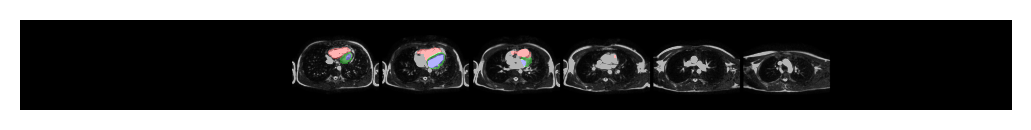

2020-12-03 07:40:28,803 INFO GT on AX


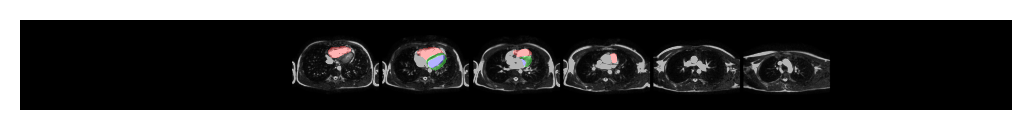

2020-12-03 07:40:29,349 INFO inv mask shape: (24, 256, 256, 4), gt mask shape: (24, 256, 256, 4)
2020-12-03 07:40:29,357 INFO DICE LV: 0.8512676954269409
2020-12-03 07:40:29,364 INFO DICE RV: 0.862918496131897
2020-12-03 07:40:29,371 INFO DICE MYO: 0.6680692434310913
2020-12-03 07:40:29,434 INFO m: [[ 0.5396 -0.8306  0.1373 -0.9917]
 [ 0.2969  0.3406  0.8916 -0.9893]
 [-0.7876 -0.4407  0.4307 10.18  ]]
2020-12-03 07:40:29,434 INFO m_mod: [[ 0.5396 -0.8306  0.1373 -0.4302]
 [ 0.2969  0.3406  0.8916 -0.3203]
 [-0.7876 -0.4407  0.4307  0.465 ]]
2020-12-03 07:40:29,435 INFO m_scaled: [[ 0.5396 -0.8306  0.1373 -0.8604]
 [ 0.2969  0.3406  0.8916 -0.6406]
 [-0.7876 -0.4407  0.4307  0.93  ]]
2020-12-03 07:40:29,437 INFO 0000-D9HN2LZW_2007-03-23_ED_msk.nrrd
2020-12-03 07:40:34,618 INFO DICE LV: 0.913807213306427
2020-12-03 07:40:34,706 INFO DICE RV: 0.7262914180755615
2020-12-03 07:40:34,795 INFO DICE MYO: 0.6883270144462585
2020-12-03 07:40:35,347 INFO Predicted mask rotated to AX on original 

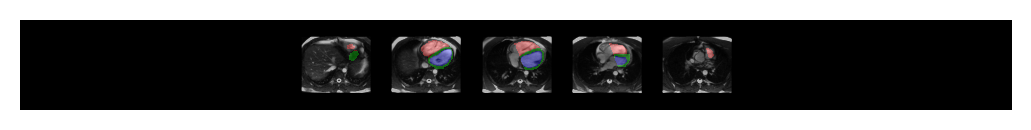

2020-12-03 07:40:35,771 INFO GT on AX


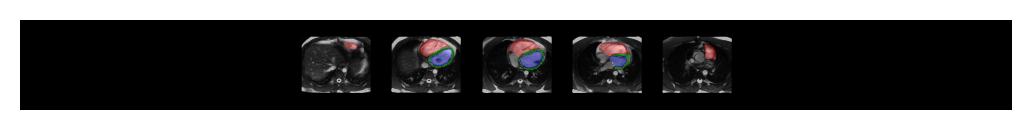

2020-12-03 07:40:36,212 INFO inv mask shape: (20, 156, 192, 4), gt mask shape: (20, 156, 192, 4)
2020-12-03 07:40:36,216 INFO DICE LV: 0.9177587628364563
2020-12-03 07:40:36,219 INFO DICE RV: 0.7274298071861267
2020-12-03 07:40:36,222 INFO DICE MYO: 0.6911832690238953
2020-12-03 07:40:36,282 INFO m: [[ 0.558  -0.807   0.1943 -0.989 ]
 [ 0.2903  0.4092  0.865  -0.9854]
 [-0.7773 -0.4263  0.4624  9.49  ]]
2020-12-03 07:40:36,283 INFO m_mod: [[ 0.558  -0.807   0.1943 -0.4077]
 [ 0.2903  0.4092  0.865  -0.3027]
 [-0.7773 -0.4263  0.4624  0.434 ]]
2020-12-03 07:40:36,283 INFO m_scaled: [[ 0.558  -0.807   0.1943 -0.8154]
 [ 0.2903  0.4092  0.865  -0.6055]
 [-0.7773 -0.4263  0.4624  0.868 ]]
2020-12-03 07:40:36,285 INFO 0000-D9HN2LZW_2007-03-23_ES_msk.nrrd
2020-12-03 07:40:41,488 INFO DICE LV: 0.8307589888572693
2020-12-03 07:40:41,575 INFO DICE RV: 0.6391711831092834
2020-12-03 07:40:41,662 INFO DICE MYO: 0.7298475503921509
2020-12-03 07:40:42,200 INFO Predicted mask rotated to AX on origina

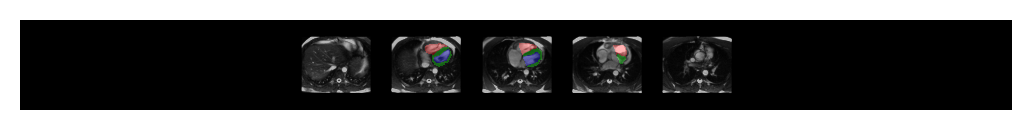

2020-12-03 07:40:42,617 INFO GT on AX


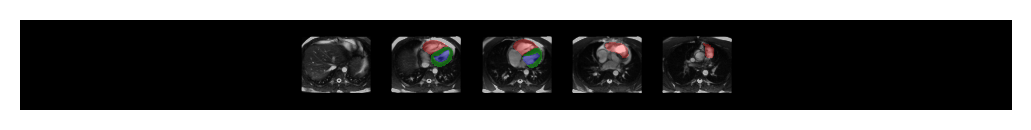

2020-12-03 07:40:43,054 INFO inv mask shape: (20, 156, 192, 4), gt mask shape: (20, 156, 192, 4)
2020-12-03 07:40:43,059 INFO DICE LV: 0.8389735817909241
2020-12-03 07:40:43,062 INFO DICE RV: 0.6417282819747925
2020-12-03 07:40:43,066 INFO DICE MYO: 0.7381230592727661
2020-12-03 07:40:43,127 INFO m: [[ 0.554  -0.8125  0.1816 -0.9897]
 [ 0.2922  0.3936  0.8716 -0.9863]
 [-0.78   -0.4297  0.4558  9.65  ]]
2020-12-03 07:40:43,127 INFO m_mod: [[ 0.554  -0.8125  0.1816 -0.4126]
 [ 0.2922  0.3936  0.8716 -0.3071]
 [-0.78   -0.4297  0.4558  0.441 ]]
2020-12-03 07:40:43,128 INFO m_scaled: [[ 0.554  -0.8125  0.1816 -0.825 ]
 [ 0.2922  0.3936  0.8716 -0.6143]
 [-0.78   -0.4297  0.4558  0.882 ]]
2020-12-03 07:40:43,128 INFO 0000-E18NUCU2_2005-05-19_ED_msk.nrrd
2020-12-03 07:40:48,368 INFO DICE LV: 0.9226040244102478
2020-12-03 07:40:48,456 INFO DICE RV: 0.8969271183013916
2020-12-03 07:40:48,544 INFO DICE MYO: 0.6471362113952637
2020-12-03 07:40:49,079 INFO Predicted mask rotated to AX on origina

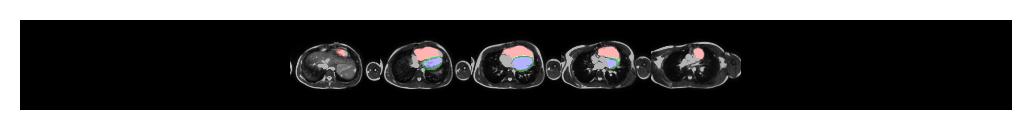

2020-12-03 07:40:49,504 INFO GT on AX


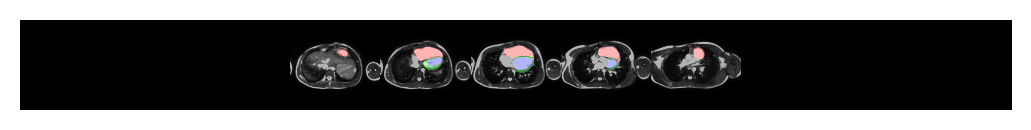

2020-12-03 07:40:50,033 INFO inv mask shape: (18, 256, 256, 4), gt mask shape: (18, 256, 256, 4)
2020-12-03 07:40:50,040 INFO DICE LV: 0.921827495098114
2020-12-03 07:40:50,045 INFO DICE RV: 0.9083607196807861
2020-12-03 07:40:50,051 INFO DICE MYO: 0.6660553812980652
2020-12-03 07:40:50,115 INFO m: [[ 0.5312  -0.8403   0.10724 -0.993  ]
 [ 0.3003   0.3054   0.904   -0.9907 ]
 [-0.792   -0.448    0.4146  10.516  ]]
2020-12-03 07:40:50,116 INFO m_mod: [[ 0.5312  -0.8403   0.10724 -0.441  ]
 [ 0.3003   0.3054   0.904   -0.329  ]
 [-0.792   -0.448    0.4146   0.4807 ]]
2020-12-03 07:40:50,116 INFO m_scaled: [[ 0.5312  -0.8403   0.10724 -0.882  ]
 [ 0.3003   0.3054   0.904   -0.658  ]
 [-0.792   -0.448    0.4146   0.9614 ]]
2020-12-03 07:40:50,118 INFO 0000-E18NUCU2_2005-05-19_ES_msk.nrrd
2020-12-03 07:40:55,361 INFO DICE LV: 0.8791936039924622
2020-12-03 07:40:55,455 INFO DICE RV: 0.8310745358467102
2020-12-03 07:40:55,541 INFO DICE MYO: 0.6834999322891235
2020-12-03 07:40:56,075 INFO Pred

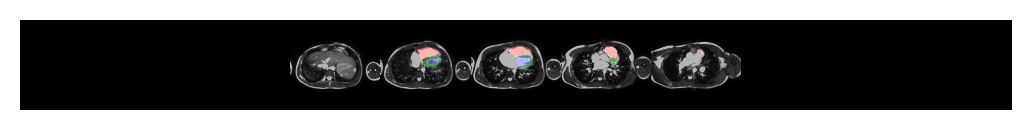

2020-12-03 07:40:56,500 INFO GT on AX


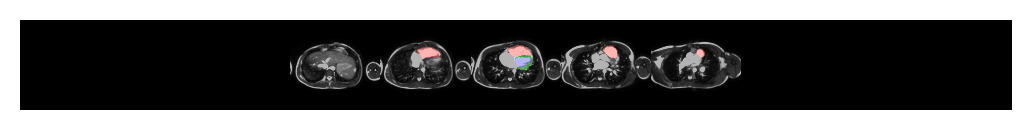

2020-12-03 07:40:57,029 INFO inv mask shape: (18, 256, 256, 4), gt mask shape: (18, 256, 256, 4)
2020-12-03 07:40:57,034 INFO DICE LV: 0.9034212231636047
2020-12-03 07:40:57,039 INFO DICE RV: 0.8296065926551819
2020-12-03 07:40:57,044 INFO DICE MYO: 0.6763753890991211
2020-12-03 07:40:57,106 INFO m: [[ 0.5312 -0.841   0.1053 -0.993 ]
 [ 0.3008  0.3035  0.904  -0.9907]
 [-0.792  -0.4485  0.414  10.54  ]]
2020-12-03 07:40:57,107 INFO m_mod: [[ 0.5312 -0.841   0.1053 -0.4414]
 [ 0.3008  0.3035  0.904  -0.3296]
 [-0.792  -0.4485  0.414   0.4814]]
2020-12-03 07:40:57,107 INFO m_scaled: [[ 0.5312 -0.841   0.1053 -0.883 ]
 [ 0.3008  0.3035  0.904  -0.659 ]
 [-0.792  -0.4485  0.414   0.963 ]]
2020-12-03 07:40:57,109 INFO 0000-E8030CFZ_2007-01-03_ED_msk.nrrd
2020-12-03 07:41:03,365 INFO DICE LV: 0.920635998249054
2020-12-03 07:41:03,453 INFO DICE RV: 0.8090986013412476
2020-12-03 07:41:03,541 INFO DICE MYO: 0.6715815663337708
2020-12-03 07:41:04,093 INFO Predicted mask rotated to AX on original

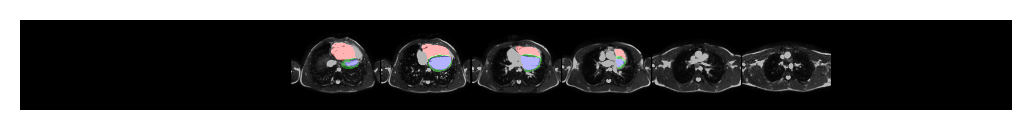

2020-12-03 07:41:04,536 INFO GT on AX


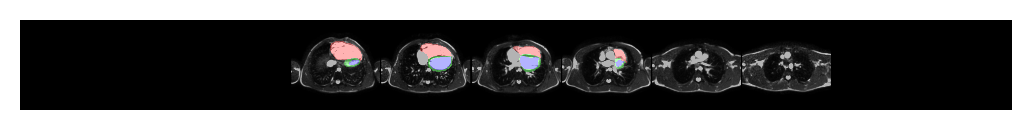

2020-12-03 07:41:05,089 INFO inv mask shape: (24, 256, 256, 4), gt mask shape: (24, 256, 256, 4)
2020-12-03 07:41:05,098 INFO DICE LV: 0.9265150427818298
2020-12-03 07:41:05,105 INFO DICE RV: 0.8131142854690552
2020-12-03 07:41:05,113 INFO DICE MYO: 0.6775662302970886
2020-12-03 07:41:05,172 INFO m: [[ 0.5474 -0.821   0.1624 -0.9907]
 [ 0.2942  0.3704  0.881  -0.988 ]
 [-0.783  -0.4346  0.4443  9.88  ]]
2020-12-03 07:41:05,173 INFO m_mod: [[ 0.5474 -0.821   0.1624 -0.4204]
 [ 0.2942  0.3704  0.881  -0.313 ]
 [-0.783  -0.4346  0.4443  0.4517]]
2020-12-03 07:41:05,173 INFO m_scaled: [[ 0.5474 -0.821   0.1624 -0.841 ]
 [ 0.2942  0.3704  0.881  -0.626 ]
 [-0.783  -0.4346  0.4443  0.9033]]
2020-12-03 07:41:05,174 INFO 0000-E8030CFZ_2007-01-03_ES_msk.nrrd
2020-12-03 07:41:10,398 INFO DICE LV: 0.8581331968307495
2020-12-03 07:41:10,485 INFO DICE RV: 0.7747860550880432
2020-12-03 07:41:10,573 INFO DICE MYO: 0.7327026128768921
2020-12-03 07:41:11,121 INFO Predicted mask rotated to AX on origina

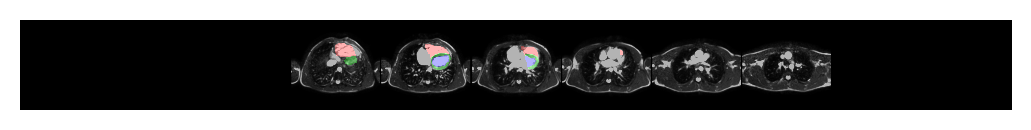

2020-12-03 07:41:11,548 INFO GT on AX


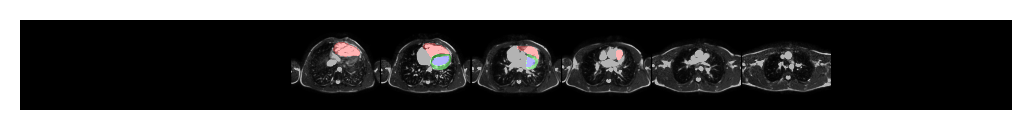

2020-12-03 07:41:12,113 INFO inv mask shape: (24, 256, 256, 4), gt mask shape: (24, 256, 256, 4)
2020-12-03 07:41:12,120 INFO DICE LV: 0.8530229330062866
2020-12-03 07:41:12,127 INFO DICE RV: 0.7735243439674377
2020-12-03 07:41:12,135 INFO DICE MYO: 0.7251921892166138
2020-12-03 07:41:12,195 INFO m: [[ 0.538  -0.833   0.1312 -0.992 ]
 [ 0.2979  0.3333  0.8945 -0.9897]
 [-0.7886 -0.4424  0.4275 10.24  ]]
2020-12-03 07:41:12,196 INFO m_mod: [[ 0.538  -0.833   0.1312 -0.4316]
 [ 0.2979  0.3333  0.8945 -0.3223]
 [-0.7886 -0.4424  0.4275  0.468 ]]
2020-12-03 07:41:12,196 INFO m_scaled: [[ 0.538  -0.833   0.1312 -0.8633]
 [ 0.2979  0.3333  0.8945 -0.6445]
 [-0.7886 -0.4424  0.4275  0.936 ]]
2020-12-03 07:41:12,197 INFO 0000-GZ4M6Z9G_2006-12-07_ED_msk.nrrd
2020-12-03 07:41:18,514 INFO DICE LV: 0.9296232461929321
2020-12-03 07:41:18,602 INFO DICE RV: 0.8373299837112427
2020-12-03 07:41:18,690 INFO DICE MYO: 0.7123633027076721
2020-12-03 07:41:19,236 INFO Predicted mask rotated to AX on origina

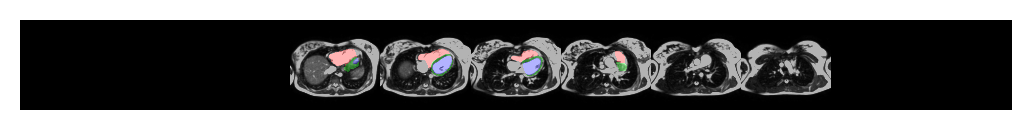

2020-12-03 07:41:19,662 INFO GT on AX


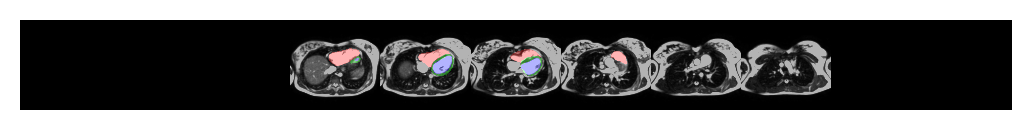

2020-12-03 07:41:20,246 INFO inv mask shape: (25, 240, 240, 4), gt mask shape: (25, 240, 240, 4)
2020-12-03 07:41:20,252 INFO DICE LV: 0.9354341626167297
2020-12-03 07:41:20,258 INFO DICE RV: 0.8522893786430359
2020-12-03 07:41:20,265 INFO DICE MYO: 0.727293074131012
2020-12-03 07:41:20,324 INFO m: [[ 0.5396 -0.8306  0.1373 -0.9917]
 [ 0.2966  0.3406  0.8916 -0.9893]
 [-0.7876 -0.4404  0.4302 10.195 ]]
2020-12-03 07:41:20,326 INFO m_mod: [[ 0.5396 -0.8306  0.1373 -0.4307]
 [ 0.2966  0.3406  0.8916 -0.3203]
 [-0.7876 -0.4404  0.4302  0.466 ]]
2020-12-03 07:41:20,326 INFO m_scaled: [[ 0.5396 -0.8306  0.1373 -0.8613]
 [ 0.2966  0.3406  0.8916 -0.6406]
 [-0.7876 -0.4404  0.4302  0.932 ]]
2020-12-03 07:41:20,327 INFO 0000-GZ4M6Z9G_2006-12-07_ES_msk.nrrd
2020-12-03 07:41:25,557 INFO DICE LV: 0.8553860783576965
2020-12-03 07:41:25,653 INFO DICE RV: 0.6812822222709656
2020-12-03 07:41:25,740 INFO DICE MYO: 0.734254002571106
2020-12-03 07:41:26,276 INFO Predicted mask rotated to AX on original 

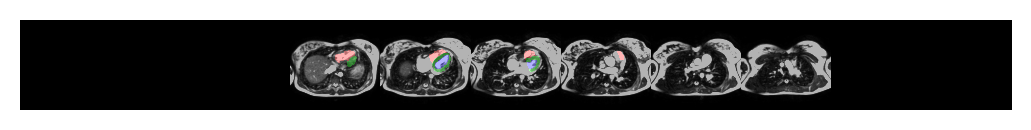

2020-12-03 07:41:26,710 INFO GT on AX


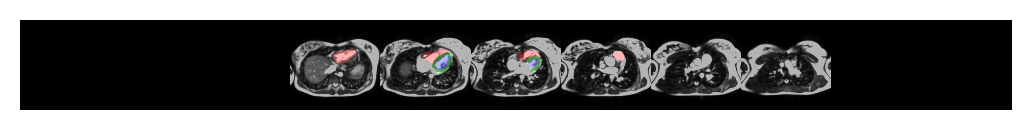

2020-12-03 07:41:27,295 INFO inv mask shape: (25, 240, 240, 4), gt mask shape: (25, 240, 240, 4)
2020-12-03 07:41:27,304 INFO DICE LV: 0.8737667202949524
2020-12-03 07:41:27,312 INFO DICE RV: 0.6750035881996155
2020-12-03 07:41:27,320 INFO DICE MYO: 0.7504251599311829
2020-12-03 07:41:27,389 INFO m: [[ 0.534  -0.8364  0.119  -0.9927]
 [ 0.299   0.319   0.899  -0.99  ]
 [-0.7905 -0.4448  0.4207 10.41  ]]
2020-12-03 07:41:27,390 INFO m_mod: [[ 0.534  -0.8364  0.119  -0.4375]
 [ 0.299   0.319   0.899  -0.3257]
 [-0.7905 -0.4448  0.4207  0.4756]]
2020-12-03 07:41:27,390 INFO m_scaled: [[ 0.534  -0.8364  0.119  -0.875 ]
 [ 0.299   0.319   0.899  -0.6514]
 [-0.7905 -0.4448  0.4207  0.951 ]]
2020-12-03 07:41:27,391 INFO 0000-HNE7CVMU_2006-10-27_ED_msk.nrrd
2020-12-03 07:41:32,641 INFO DICE LV: 0.8682141304016113
2020-12-03 07:41:32,742 INFO DICE RV: 0.7328934073448181
2020-12-03 07:41:32,831 INFO DICE MYO: 0.6357985734939575
2020-12-03 07:41:33,377 INFO Predicted mask rotated to AX on origina

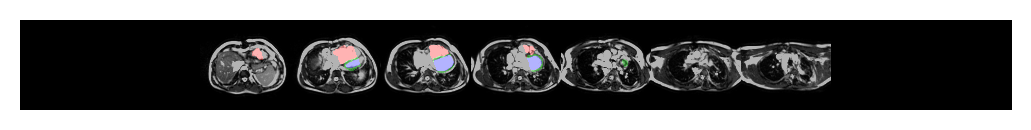

2020-12-03 07:41:33,807 INFO GT on AX


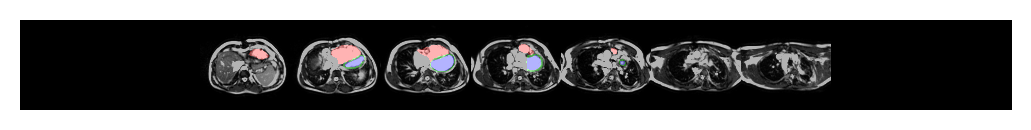

2020-12-03 07:41:34,394 INFO inv mask shape: (27, 256, 256, 4), gt mask shape: (27, 256, 256, 4)
2020-12-03 07:41:34,409 INFO DICE LV: 0.8739109635353088
2020-12-03 07:41:34,419 INFO DICE RV: 0.7469348311424255
2020-12-03 07:41:34,428 INFO DICE MYO: 0.6416394710540771
2020-12-03 07:41:34,492 INFO m: [[ 0.516   -0.8555   0.04514 -0.995  ]
 [ 0.3074   0.234    0.923   -0.993  ]
 [-0.8     -0.4622   0.3835  11.22   ]]
2020-12-03 07:41:34,492 INFO m_mod: [[ 0.516   -0.8555   0.04514 -0.462  ]
 [ 0.3074   0.234    0.923   -0.3462 ]
 [-0.8     -0.4622   0.3835   0.512  ]]
2020-12-03 07:41:34,493 INFO m_scaled: [[ 0.516   -0.8555   0.04514 -0.924  ]
 [ 0.3074   0.234    0.923   -0.6924 ]
 [-0.8     -0.4622   0.3835   1.024  ]]
2020-12-03 07:41:34,494 INFO 0000-HNE7CVMU_2006-10-27_ES_msk.nrrd
2020-12-03 07:41:39,721 INFO DICE LV: 0.8509396910667419
2020-12-03 07:41:39,821 INFO DICE RV: 0.6952441334724426
2020-12-03 07:41:39,909 INFO DICE MYO: 0.7805691361427307
2020-12-03 07:41:40,466 INFO Pre

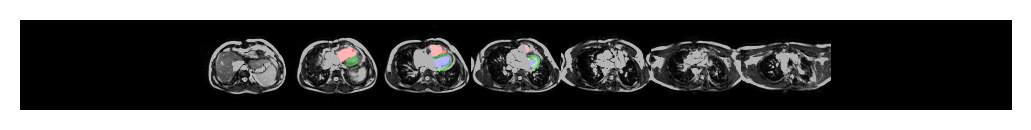

2020-12-03 07:41:40,895 INFO GT on AX


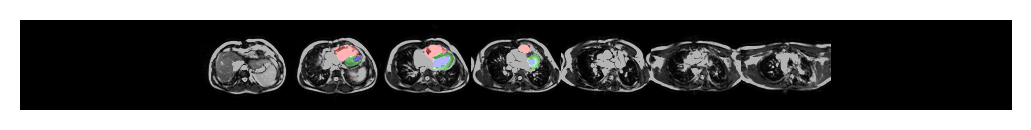

2020-12-03 07:41:41,467 INFO inv mask shape: (27, 256, 256, 4), gt mask shape: (27, 256, 256, 4)
2020-12-03 07:41:41,476 INFO DICE LV: 0.847004234790802
2020-12-03 07:41:41,484 INFO DICE RV: 0.7062695026397705
2020-12-03 07:41:41,492 INFO DICE MYO: 0.7824035286903381
2020-12-03 07:41:41,555 INFO m: [[ 0.5117  -0.8584   0.02774 -0.9956 ]
 [ 0.3088   0.214    0.9263  -0.9937 ]
 [-0.802   -0.4656   0.3748  11.414  ]]
2020-12-03 07:41:41,555 INFO m_mod: [[ 0.5117  -0.8584   0.02774 -0.4678 ]
 [ 0.3088   0.214    0.9263  -0.351  ]
 [-0.802   -0.4656   0.3748   0.521  ]]
2020-12-03 07:41:41,556 INFO m_scaled: [[ 0.5117  -0.8584   0.02774 -0.9355 ]
 [ 0.3088   0.214    0.9263  -0.702  ]
 [-0.802   -0.4656   0.3748   1.042  ]]
2020-12-03 07:41:41,557 INFO 0000-KK9VRLND_2006-07-10_ED_msk.nrrd
2020-12-03 07:41:46,732 INFO DICE LV: 0.9108394384384155
2020-12-03 07:41:46,828 INFO DICE RV: 0.817888081073761
2020-12-03 07:41:46,931 INFO DICE MYO: 0.6297636032104492
2020-12-03 07:41:47,492 INFO Predi

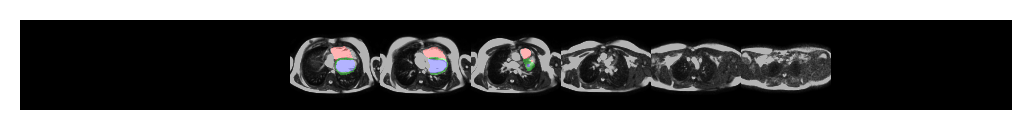

2020-12-03 07:41:50,868 INFO GT on AX


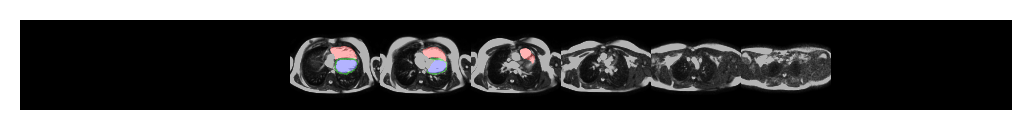

2020-12-03 07:41:51,394 INFO inv mask shape: (26, 256, 256, 4), gt mask shape: (26, 256, 256, 4)
2020-12-03 07:41:51,403 INFO DICE LV: 0.9103070497512817
2020-12-03 07:41:51,412 INFO DICE RV: 0.8260441422462463
2020-12-03 07:41:51,420 INFO DICE MYO: 0.6232373714447021
2020-12-03 07:41:51,465 INFO m: [[ 0.524  -0.848   0.0787 -0.994 ]
 [ 0.3037  0.2722  0.913  -0.992 ]
 [-0.796  -0.4543  0.4    10.85  ]]
2020-12-03 07:41:51,466 INFO m_mod: [[ 0.524  -0.848   0.0787 -0.4512]
 [ 0.3037  0.2722  0.913  -0.337 ]
 [-0.796  -0.4543  0.4     0.496 ]]
2020-12-03 07:41:51,466 INFO m_scaled: [[ 0.524  -0.848   0.0787 -0.9023]
 [ 0.3037  0.2722  0.913  -0.674 ]
 [-0.796  -0.4543  0.4     0.992 ]]
2020-12-03 07:41:51,468 INFO 0000-KK9VRLND_2006-07-10_ES_msk.nrrd
2020-12-03 07:41:56,898 INFO DICE LV: 0.7853876352310181
2020-12-03 07:41:56,969 INFO DICE RV: 0.6906744837760925
2020-12-03 07:41:57,042 INFO DICE MYO: 0.6044090390205383
2020-12-03 07:41:57,559 INFO Predicted mask rotated to AX on origina

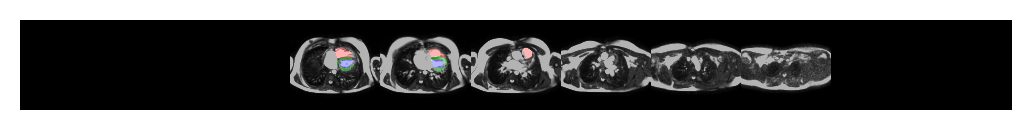

2020-12-03 07:41:57,982 INFO GT on AX


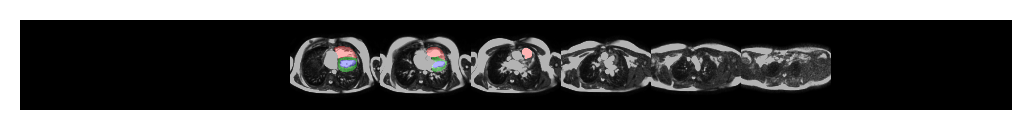

2020-12-03 07:41:58,485 INFO inv mask shape: (26, 256, 256, 4), gt mask shape: (26, 256, 256, 4)
2020-12-03 07:41:58,493 INFO DICE LV: 0.8122381567955017
2020-12-03 07:41:58,501 INFO DICE RV: 0.6819723844528198
2020-12-03 07:41:58,509 INFO DICE MYO: 0.623271644115448
2020-12-03 07:41:58,553 INFO m: [[ 0.521  -0.851   0.0674 -0.994 ]
 [ 0.3047  0.259   0.917  -0.9927]
 [-0.7974 -0.457   0.3943 10.98  ]]
2020-12-03 07:41:58,554 INFO m_mod: [[ 0.521  -0.851   0.0674 -0.4546]
 [ 0.3047  0.259   0.917  -0.3403]
 [-0.7974 -0.457   0.3943  0.5015]]
2020-12-03 07:41:58,554 INFO m_scaled: [[ 0.521  -0.851   0.0674 -0.909 ]
 [ 0.3047  0.259   0.917  -0.6807]
 [-0.7974 -0.457   0.3943  1.003 ]]
2020-12-03 07:41:58,555 INFO 0000-TET48V2Z_2008-01-10_ED_msk.nrrd
2020-12-03 07:42:03,858 INFO DICE LV: 0.8964688181877136
2020-12-03 07:42:03,932 INFO DICE RV: 0.8678916096687317
2020-12-03 07:42:04,004 INFO DICE MYO: 0.6678887009620667
2020-12-03 07:42:04,520 INFO Predicted mask rotated to AX on original

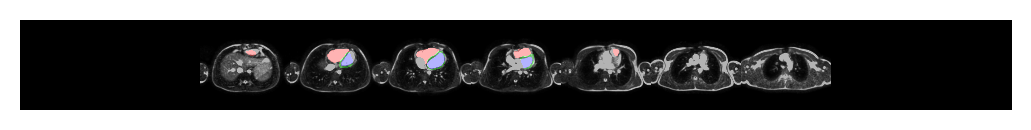

2020-12-03 07:42:04,955 INFO GT on AX


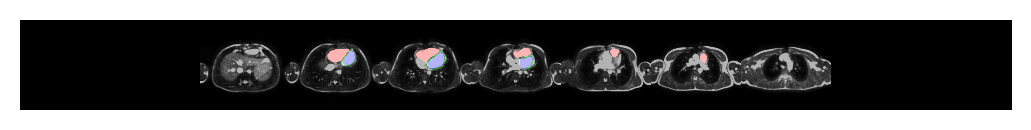

2020-12-03 07:42:05,494 INFO inv mask shape: (23, 256, 256, 4), gt mask shape: (23, 256, 256, 4)
2020-12-03 07:42:05,502 INFO DICE LV: 0.8969481587409973
2020-12-03 07:42:05,509 INFO DICE RV: 0.8745977282524109
2020-12-03 07:42:05,516 INFO DICE MYO: 0.6769806742668152
2020-12-03 07:42:05,561 INFO m: [[ 0.5464 -0.8223  0.1575 -0.9907]
 [ 0.2952  0.365   0.883  -0.9883]
 [-0.7837 -0.436   0.4421  9.93  ]]
2020-12-03 07:42:05,562 INFO m_mod: [[ 0.5464 -0.8223  0.1575 -0.4219]
 [ 0.2952  0.365   0.883  -0.314 ]
 [-0.7837 -0.436   0.4421  0.4536]]
2020-12-03 07:42:05,562 INFO m_scaled: [[ 0.5464 -0.8223  0.1575 -0.8438]
 [ 0.2952  0.365   0.883  -0.628 ]
 [-0.7837 -0.436   0.4421  0.907 ]]
2020-12-03 07:42:05,563 INFO 0000-TET48V2Z_2008-01-10_ES_msk.nrrd
2020-12-03 07:42:10,868 INFO DICE LV: 0.8218443393707275
2020-12-03 07:42:10,940 INFO DICE RV: 0.7736461758613586
2020-12-03 07:42:11,012 INFO DICE MYO: 0.6697303652763367
2020-12-03 07:42:11,519 INFO Predicted mask rotated to AX on origina

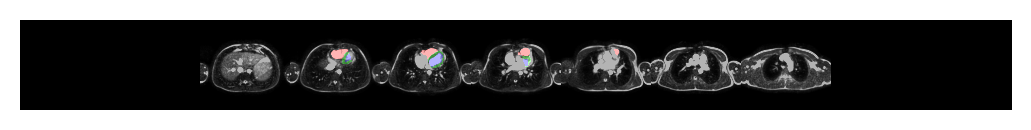

2020-12-03 07:42:11,950 INFO GT on AX


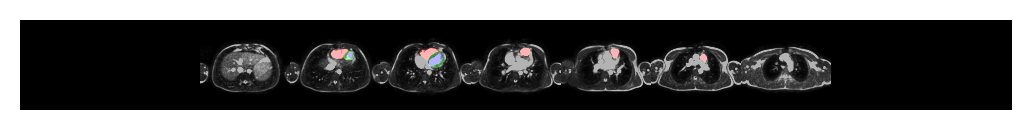

2020-12-03 07:42:12,452 INFO inv mask shape: (23, 256, 256, 4), gt mask shape: (23, 256, 256, 4)
2020-12-03 07:42:12,459 INFO DICE LV: 0.8215609192848206
2020-12-03 07:42:12,466 INFO DICE RV: 0.7754627466201782
2020-12-03 07:42:12,474 INFO DICE MYO: 0.6779195070266724
2020-12-03 07:42:12,518 INFO m: [[ 0.546  -0.8228  0.1572 -0.9907]
 [ 0.295   0.3647  0.8833 -0.9883]
 [-0.784  -0.436   0.442   9.94  ]]
2020-12-03 07:42:12,519 INFO m_mod: [[ 0.546  -0.8228  0.1572 -0.4219]
 [ 0.295   0.3647  0.8833 -0.3145]
 [-0.784  -0.436   0.442   0.454 ]]
2020-12-03 07:42:12,519 INFO m_scaled: [[ 0.546  -0.8228  0.1572 -0.8438]
 [ 0.295   0.3647  0.8833 -0.629 ]
 [-0.784  -0.436   0.442   0.908 ]]
2020-12-03 07:42:12,520 INFO 0000-Z0QR21CJ_2005-11-02_ED_msk.nrrd
2020-12-03 07:42:17,727 INFO DICE LV: 0.8958202004432678
2020-12-03 07:42:17,799 INFO DICE RV: 0.8172644376754761
2020-12-03 07:42:17,871 INFO DICE MYO: 0.6229801177978516
2020-12-03 07:42:18,392 INFO Predicted mask rotated to AX on origina

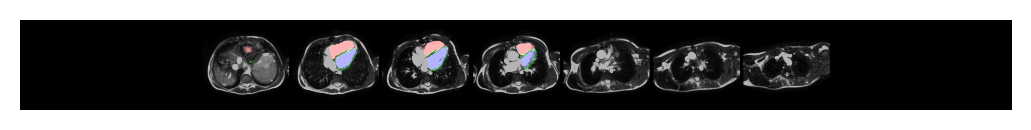

2020-12-03 07:42:18,821 INFO GT on AX


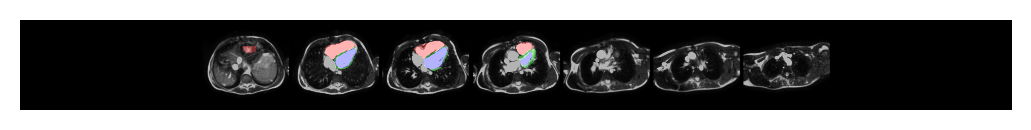

2020-12-03 07:42:19,342 INFO inv mask shape: (26, 256, 256, 4), gt mask shape: (26, 256, 256, 4)
2020-12-03 07:42:19,351 INFO DICE LV: 0.8994985222816467
2020-12-03 07:42:19,358 INFO DICE RV: 0.8055533766746521
2020-12-03 07:42:19,366 INFO DICE MYO: 0.6473063230514526
2020-12-03 07:42:19,411 INFO m: [[ 0.5283  -0.8438   0.09607 -0.9937 ]
 [ 0.3015   0.2922   0.9077  -0.991  ]
 [-0.7935  -0.4507   0.4087  10.65   ]]
2020-12-03 07:42:19,411 INFO m_mod: [[ 0.5283  -0.8438   0.09607 -0.4443 ]
 [ 0.3015   0.2922   0.9077  -0.332  ]
 [-0.7935  -0.4507   0.4087   0.4866 ]]
2020-12-03 07:42:19,412 INFO m_scaled: [[ 0.5283  -0.8438   0.09607 -0.8887 ]
 [ 0.3015   0.2922   0.9077  -0.664  ]
 [-0.7935  -0.4507   0.4087   0.973  ]]
2020-12-03 07:42:19,412 INFO 0000-Z0QR21CJ_2005-11-02_ES_msk.nrrd
2020-12-03 07:42:24,610 INFO DICE LV: 0.857886016368866
2020-12-03 07:42:24,682 INFO DICE RV: 0.7086135149002075
2020-12-03 07:42:24,753 INFO DICE MYO: 0.6201019287109375
2020-12-03 07:42:25,270 INFO Pred

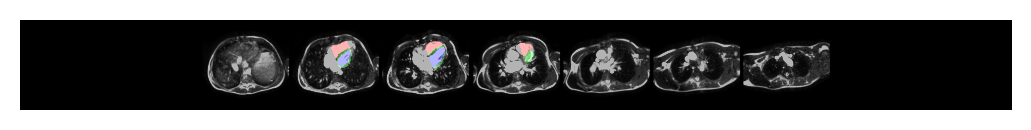

2020-12-03 07:42:25,696 INFO GT on AX


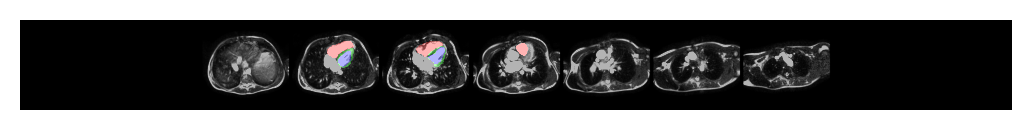

2020-12-03 07:42:26,194 INFO inv mask shape: (26, 256, 256, 4), gt mask shape: (26, 256, 256, 4)
2020-12-03 07:42:26,203 INFO DICE LV: 0.8723404407501221
2020-12-03 07:42:26,211 INFO DICE RV: 0.7106618285179138
2020-12-03 07:42:26,219 INFO DICE MYO: 0.639651358127594
2020-12-03 07:42:26,263 INFO m: [[ 0.534  -0.8384  0.1152 -0.9927]
 [ 0.2998  0.3147  0.901  -0.99  ]
 [-0.791  -0.4463  0.4192 10.43  ]]
2020-12-03 07:42:26,264 INFO m_mod: [[ 0.534  -0.8384  0.1152 -0.4375]
 [ 0.2998  0.3147  0.901  -0.3267]
 [-0.791  -0.4463  0.4192  0.4766]]
2020-12-03 07:42:26,264 INFO m_scaled: [[ 0.534  -0.8384  0.1152 -0.875 ]
 [ 0.2998  0.3147  0.901  -0.6533]
 [-0.791  -0.4463  0.4192  0.953 ]]


In [16]:
# predict on all test images, once with postprocessing, and once without
use_modified_translation = FOCUS_LOSS # True, if we use the unet extension to learn a second set of translation parameters
combine = False
dual_model = False
experiment_identifier = 'tests_72_112_112_sp3_1ax_1sax_1focus_thres08_inpl_f0_2nd_unet_round_crop'

logging.info('use modified translation to scale: {}'.format(use_modified_translation))
path_1 = 'data/predicted/{}/3D/'.format(experiment_identifier)
path_2 = path_1.replace('_post', '_NoPost')

# make predictions with different parameters in the same flow
for i in range(ax_full.shape[0]):
    select_image_in_batch_(im=i,slice_n=5, debug=False,export_path=path_1, save=True, postprocess=True, use_mod_translation=use_modified_translation, combine=combine, dual_model=dual_model)
    #select_image_in_batch_(im=i,slice_n=5, debug=False,export_path=path_1, save=True, postprocess=False, use_mod_translation=use_modified_translation, combine=combine, dual_model=dual_model)

In [ ]:
# Initial version, please check before execute
assert(False==True)
@interact
def select_image_in_batch(im=(0, x_.shape[0] - 1, 1), 
                          slice_n=(1, 6), 
                          export_path='data/predicted/temp/',
                          shift_z=20,
                          debug=False,
                         save=False):
    """
    Use the spatial transformer to rotate, predict segmentations, reverse the rotation on the masks and save the nrrd files (image, gt and pred)
    :param im: slider to select another image from the generator
    :param slice_n: The show_2D_3D method slices to a maximum of 20 slices in z, this parameter allows to further slice the visualisations
    :param export_path: path to save the img, gt and prediction volumes as nrrd file, the file names will be the same as in x_ax_val...
    :param debug: bool to enable plotting of the intermediate steps
    :return: void
    """
    global m

    full_file_name = y_val_ax[im]
    filename = os.path.basename(full_file_name)
    logging.info(filename)
    temp = x_[im]
    temp_ = y_[im]
    ax_full_ = ax_full[im]
    ax_msk_full_gt = ax_msk_[im]
    
    # define a different logging level to make the generator steps visible
    logging.getLogger().setLevel(logging.INFO)
    logging.info('Prediction on AX volume:')
    if debug: show_2D_or_3D(temp[::slice_n])
    plt.show()
    
    # Predict rotation of AX and get transformation matrix
    logging.info('AX --> SAX rotated by the model')
    pred, m, mask_pred= model.predict(np.expand_dims(temp, axis=0))
    if debug: show_2D_or_3D(pred[0][::slice_n])
    plt.show()
    
    # make copy of m for reusage
    #m_ = m.copy()
    m = np.reshape(m, (3,4))
    # scale translation part of the affine matrix from spacing 5 to 1.5
    m_t = m[:,3]
    m_t = (m_t *5)/1.5
    m[:,3] = m_t
    m_ = m.flatten()
    
    # show the target AXtoSAX volume
    logging.getLogger().setLevel(logging.INFO)
    logging.info('Target (SAX):')
    if debug: show_2D_or_3D(temp_[::slice_n])
    plt.show()
    
    # Repeat the transformation on ax with full resolution
    logging.info('Repeat the transformation on the full resolution')
    logging.getLogger().setLevel(logging.ERROR)
    transformer = create_affine_transformer_fixed(config=msk_cfg, interp_method='linear')
    pred, m_ = transformer.predict(x=[np.expand_dims(ax_full_, axis=0), np.expand_dims(m_,axis=0)])
    if debug: show_2D_or_3D(pred[0][::slice_n*3])
    plt.show()
    
    # reshape m to matrix
    m = np.reshape(m, (3, 4))

    # create a square ident matrix slice m into it
    m_matrix = np.identity(4)
    # slice m (3,4) into identity (4,4)
    m_matrix[:3, :] = m
    # calc inverse, flatten the matrix and cut off the last row for the spatial transformer
    m_matrix_inverse = np.linalg.inv(m_matrix)
    m_matrix_inverse_flatten = m_matrix_inverse.flatten()[:-4]

    # apply the inverse to our AXtoSAX volume
    logging.getLogger().setLevel(logging.INFO)
    logging.info('Apply the invers rotation to our AXtoSAX')
    logging.getLogger().setLevel(logging.ERROR)
    inv, _ = transformer.predict(x=[pred, np.expand_dims(m_matrix_inverse_flatten, axis=0)])
    if debug: show_2D_or_3D(inv[0][::slice_n*3])
    plt.show()

    # load a 3D wrapper model for segmenting the new SAX
    if 'unet' in globals():
        msk = unet.predict(x=pred)
        msk = clean_3d_prediction_3d_cc(from_channel_to_flat(msk[0] >= 0.5))
        msk = transform_to_binary_mask(msk)
        logging.getLogger().setLevel(logging.INFO)
        logging.info('Predicted mask')
        if debug: show_2D_or_3D(pred[0][::slice_n*3], msk[::slice_n*3])
        plt.show()

        # apply inverse to our msk and plot it together with the inverse AXtoSAX
        logging.getLogger().setLevel(logging.ERROR)
        m_transformer = create_affine_transformer_fixed(config=msk_cfg, interp_method='nearest')
        inv_msk = list()
        for c in range(msk.shape[-1]):
            inv_m, _ = m_transformer.predict(
                x=[np.expand_dims(msk[..., c], axis=0), np.expand_dims(m_matrix_inverse_flatten, axis=0)])
            inv_msk.append(inv_m[..., 0] >= 0.5)
        inv_msk = np.stack(inv_msk, axis=-1)
        
        # postprocessing
        logging.getLogger().setLevel(logging.INFO)
        logging.info('Predicted mask rotated to AX on original AX image - before postprocessing')
        if debug: show_2D_or_3D(ax_full_[::slice_n*3], inv_msk[0][::slice_n*3])
        plt.show()
        
        inv_msk = from_channel_to_flat(inv_msk[0])
        kernel = np.ones((5,5),np.uint8)
        kernel_small = np.ones((3,3),np.uint8)
        
        inv_msk = clean_3d_prediction_3d_cc(inv_msk)
        logging.info('Predicted mask rotated to AX on original AX image - after connected component filtering')
        if debug: show_2D_or_3D(ax_full_[::slice_n*3], inv_msk[::slice_n*3])
        plt.show()
        
        inv_msk = np.stack([cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel_small) for img in inv_msk],axis=0)
        logging.info('Predicted mask rotated to AX on original AX image - after closing')
        if debug: show_2D_or_3D(ax_full_[::slice_n*3], inv_msk[::slice_n*3])
        plt.show()
        
        inv_msk = np.stack([cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel, iterations=2) for img in inv_msk],axis=0)
        logging.info('Predicted mask rotated to AX on original AX image - after opening')
        if debug: show_2D_or_3D(ax_full_[::slice_n*3], inv_msk[::slice_n*3])
        plt.show()
        
        inv_msk = np.stack([cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel) for img in inv_msk],axis=0)
        logging.info('Predicted mask rotated to AX on original AX image - after closing')
        if debug: show_2D_or_3D(ax_full_[::slice_n*3], inv_msk[::slice_n*3])
        plt.show()
        
        inv_msk = clean_3d_prediction_3d_cc(inv_msk)
        logging.info('Predicted mask rotated to AX on original AX image - after connected component filtering')
        if debug: show_2D_or_3D(ax_full_, inv_msk)
        plt.show()

        logging.getLogger().setLevel(logging.INFO)
        logging.info('Predicted mask rotated to AX on inverse AXtoSAX')
        if debug: show_2D_or_3D(inv[0][::slice_n*3], inv_msk[::slice_n*3])
        plt.show()
        logging.info('Predicted mask rotated to AX on original AX image')
        show_2D_or_3D(ax_full_[::slice_n*3], inv_msk[::slice_n*3])
        plt.show()
        
        # get the AX target segmentation, processed by the generator to have it in the same shape
        #msk_flatten = clean_3d_prediction_3d_cc(from_channel_to_flat(inv_msk[0]))
        msk_gt_flatten = from_channel_to_flat(ax_msk_full_gt)
        logging.info('GT on AX')
        show_2D_or_3D(ax_full_[::slice_n*3], msk_gt_flatten[::slice_n*3])
        plt.show()
        
        # create a nrrd file for the gt, pred and image volume
        sitk_pred = sitk.GetImageFromArray(inv_msk)
        sitk_ax_img = sitk.GetImageFromArray(ax_full_)
        sitk_ax_msk = sitk.GetImageFromArray(msk_gt_flatten)

        ensure_dir(os.path.join(export_path, 'pred'))
        ensure_dir(os.path.join(export_path, 'image'))
        ensure_dir(os.path.join(export_path, 'gt'))
        
        # load a reference nrrd file, copy all metadata and save the volumes
        reference_sitk = sitk.ReadImage(full_file_name)
        if save:
            copy_meta_and_save(sitk_pred, reference_sitk, os.path.join(export_path, 'pred', filename))
            copy_meta_and_save(sitk_ax_img, reference_sitk,os.path.join(export_path, 'image', filename.replace('msk', 'img')))
            copy_meta_and_save(sitk_ax_msk, reference_sitk, os.path.join(export_path, 'gt', filename))
        # shutil.copyfile(full_file_name, os.path.join(export_path, 'gt', filename))
    else:
        logging.info('no unet in global namespace, segmentation is not possible')

    logging.info('MSE: {}'.format(mse(pred[0], ax_full_).numpy().mean()))
    #logging.info('MSE center cube: {}'.format(metr.cubic_center_loss_wrapper(pred[0], temp_).numpy().mean()))
    try:
        print(np.reshape(m[0], (3, 4)))
    except Exception as e:
        pass


# Further tests, where do our model fail, do we over- or under-segment

In [20]:
gt.shape

(144, 224, 224, 3)

In [21]:
zero = np.zeros_like(gt[...,0:1])
temp = np.concatenate((zero,gt),axis=-1)
temp.shape

(144, 224, 224, 4)

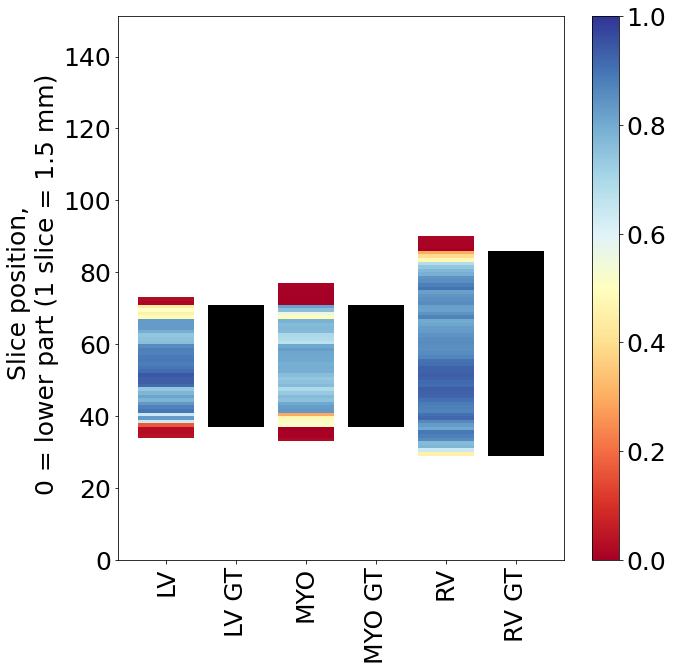

In [22]:
from src.visualization.Visualize import plot_dice_per_slice_bar, plot_dice_per_slice_line
plot_dice_per_slice_bar(gt,pred)

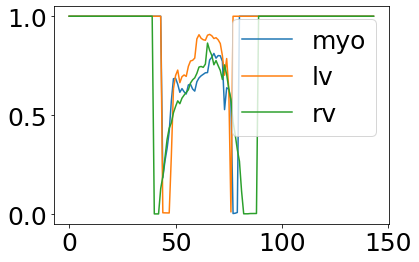

In [31]:
# Create a lineplot for the errors within the volume
plot_dice_per_slice_line(gt,pred)

# Temp tests

In [ ]:
cmap(1)

In [ ]:
# check the memory usage
import sys

# These are the usual ipython objects, including this one you are creating
ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

# Get a sorted list of the objects and their sizes
sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)
